In [292]:
import numpy as np
import matplotlib.pyplot as plt
import pydot
import pickle
import pathlib
import os
from scipy import stats
import random
from sklearn.metrics import r2_score
plt.rcParams['figure.figsize'] = [10, 5]
#import unicode

from scipy.optimize import curve_fit
import re
from sklearn.cluster import AgglomerativeClustering
import pandas as pd
import statistics
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from sklearn.neighbors import NearestNeighbors
from scipy.spatial import distance
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import norm

In [293]:
#directory = str(pathlib.Path(__file__).parent.resolve())
#script_path = str(pathlib.Path(__file__).parent.resolve())
directory = os.getcwd()
script_path = os.getcwd()
nameset,dictset = [],[]
refnameset,refdictset = [],[]

refsortset = []
sortset = []


for filename in os.listdir(directory):
    if filename.endswith(".txt") and '._' not in filename and 'mat' not in filename:
        if 'REF' not in filename:
            impath = os.path.join(directory, filename)
            nameset.append(impath)
            this_set = dict()
            with (open(impath, encoding = 'utf8', errors = 'ignore')) as f: #populate dict from text file
                for n in f:
                    pog = n.split('\t')
                    this_set[pog[0]] = pog[-1].count(',')
                f.close()
            try:
                this_set.pop('cell_name')
                this_set.pop('AB')
            except: pass
            dictset.append(this_set)
            sortset.append((impath, this_set))
        else:
            impath = os.path.join(directory, filename)
            refnameset.append(impath)
            this_set = dict()
            with (open(impath, encoding = 'utf8', errors = 'ignore')) as f: #populate dict from text file
                for n in f:
                    pog = n.split('\t')
                    this_set[pog[0]] = pog[-1].count(',')
                    #if pog[0] == 'P4': print(pog[0],pog[-1].count(','))
                f.close()
            try:
                this_set.pop('cell_name')
                this_set.pop('AB')
            except: pass
            refdictset.append(this_set)
            refsortset.append((impath, this_set))
            
    
print(len(dictset),len(nameset))
print(len(refdictset),len(refnameset))
truncator = len(nameset)

nameset,dictset = [],[]
for n in sorted(sortset):
    nameset.append(n[0]);dictset.append(n[1])

refnameset,refdictset = [],[]
for n in sorted(refsortset):
    refnameset.append(n[0]);refdictset.append(n[1])
    
fulldictset = refdictset + dictset;fullnameset = refnameset + nameset

1322 1322
30 30


In [294]:
def remove_dangling_children(oldshi,ref = False):
    poor = ['']+sorted(list(oldshi))+['xxxxxxxxxxxxxxxxx'];dishi = dict()
    if ref == True:
        dishi['ABa'] = oldshi['ABa']
        dishi['P2'] = oldshi['P2']
        dishi['P3'] = oldshi['P3']
    
    try: 
        dishi['ABa'] = oldshi['ABa']
        dishi['P2'] = oldshi['P2']
        dishi['P3'] = oldshi['P3']
        #print('here')
    except: pass
    #print('P2' in oldshi)
    for n in range(1,len(poor)-1):
        if (len(poor[n]) == len(poor[n+1]) or len(poor[n]) == len(poor[n-1])) == False: 
            dishi[poor[n]] = oldshi[poor[n]]
    return dishi


In [295]:
refnameset,refdictset = [],[]
for n in sorted(refsortset):
    refnameset.append(n[0]);refdictset.append(remove_dangling_children(n[1], ref = True))

In [296]:
nameset,dictset = [],[]
for n in sorted(sortset):
    nameset.append(n[0]);dictset.append(remove_dangling_children(n[1]))

In [297]:
#part 1 of common node
refnodelist = set(refdictset[0])
for n in refdictset:
    refnodelist = set(n).intersection(refnodelist)

In [298]:
#part 2 of common node
newdictset = []
for n in refdictset:
    newdict = dict()
    for i in refnodelist:
        newdict[i] = n[i]
    #print(set(newdict).issubset(set(n)))
    #print(len(newdict))
    newdictset.append(newdict)

#print(set(newdict).issubset(set(n)))
refdictset = newdictset

In [299]:
def scramble(dict_list):
    dict_return = []
    for element in dict_list:
        valuescramble = list(element.values())
        random.shuffle(valuescramble)
        keyscramble = list(element)
        random.shuffle(keyscramble)
        new_element = dict()
        for n in range(0,len(keyscramble)):
            new_element[keyscramble[n]] = valuescramble[n]
        dict_return.append(new_element)
    return dict_return
def globalize(dictn):
    globaldictset = []
    for i in dictn:
        tags = sorted(list(i));dip = dict()
        for n in tags:
            if n[0:-1] in i:
                dip[n] = i[n] + dip[n[:-1]]
            else: dip[n] = i[n]    
        globaldictset.append(dip)
    return globaldictset

In [300]:
scrambledictset = scramble(dictset)
globaldictset = globalize(dictset)
globalscrambledictset = globalize(scrambledictset)

refscrambledictset = scramble(refdictset)
refglobaldictset = globalize(refdictset)
refglobalscrambledictset = globalize(refscrambledictset)

In [301]:
qf = pd.read_csv('1368-embryos.csv', header=None).iloc[0]
df = pd.read_csv('1368-embryos.csv')
rdf = df.sort_values(by = 'embryo-ID')
cuttags = ['ABa','ABp','C','D','E','MS','P']
rearranger = [0,1,4,5,3,2,6]

match_links = [];match_links2 = []

findit = 0;notin = 0

o = 0
for n in range(0,df.shape[0]):
    #print(rdf.iloc[n][1] in nameset[o])
    if rdf.iloc[n][1] in nameset[o]:
        #match_links.append((o,n)) #, o in nameset, #n in dataframe
        match_links.append(n) #index is o in nameset, list value is n in dataframe
        tagref = 0
        for nm in list(globaldictset[o]):
            if cuttags[tagref] not in nm:
                try:
                    tagref = tagref + 1
                    if tagref > 6:
                        break
                except:
                    break
            #findit = findit + (globaldictset[o][nm] >= rdf.iloc[n][rearranger[tagref]+5])
            if (globaldictset[o][nm] >= rdf.iloc[n][rearranger[tagref]+5]): 
                #print(nameset[o].split('/')[-1])
                #print(rdf.iloc[n][1])
                #print('tag',o,'embryo',n,nm,globaldictset[o][nm],rdf.iloc[n][rearranger[tagref]+5])
                del dictset[o][nm]
        o = o + 1
    else:
        pass
        match_links2.append((o,-1))
        #match_links2.append(-1)
o,n

(1322, 1367)

In [302]:
fulldictset = refdictset + dictset;fullnameset = refnameset + nameset

In [12]:
def plot_2_examples(colormaps,imp): #heatmap matrix plotting function
    data = imp;n = len(colormaps)
    fig, axs = plt.subplots(1, n, figsize=(n, n),
                            constrained_layout=False, squeeze=False)
    for [ax, cmap] in zip(axs.flat, colormaps):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=(int(10*np.amin(imp))/10.0), vmax=(int(10*np.amax(imp))/10.0))
        fig.colorbar(psm, ax=ax)
    plt.title('Distance between times in WT C. Elegans')
    #plt.figure(figsize = (15,8))
    plt.gcf().set_size_inches(35, 25)
    plt.show()

In [456]:
def branch_distance(dict1,dict2): #issa metric from deeds
    branch_dist = 0
    for n in list(set(dict1).intersection(set(dict2))):
        branch_dist = branch_dist + (dict1[n]-dict2[n])**2
    return (np.sqrt(branch_dist))


In [ ]:
def branch_distance(dict1,dict2): #issa metric from deeds
    branch_dist = 0
    for n in list(set(dict1).intersection(set(dict2))):
        branch_dist = branch_dist + (dict1[n]-dict2[n])**2
    return (np.sqrt(branch_dist)/float(len(set(dict1).intersection(set(dict2)))))


In [308]:

def jaccard_distance(dict1,dict2):
    onion = len(set(dict1).union(set(dict2)))
    #entry = len(set(dict1).intersection(set(dict2)))
    #print((onion - len(set(dict1).intersection(set(dict2)))) / onion)
    return ((onion - len(set(dict1).intersection(set(dict2)))) / onion)
    #return (len((set(dict1).union(set(dict2))))-len((set(dict1).intersection(set(dict2)))))

def cosine_pseudodistance(dict1,dict2):
    dict1list = []; dict2list = []
    for n in list(set(dict1).intersection(set(dict2))): 
        dict1list.append(dict1[n]);dict2list.append(dict2[n])
    return cosine_similarity([dict1list], [dict2list])[0][0]



def tree_edit_distance(dict1,dict2): return (len((set(dict1).union(set(dict2))))-len((set(dict1).intersection(set(dict2)))))

In [87]:
#qf_editor = pd.read_csv('1368-embryos_edited.csv', header=None).iloc[0]
df_tree_normalized_editor = pd.read_csv('1368-embryos_edited.csv')
df_tree_normalized_editor = df_tree_normalized_editor.sort_values(by = 'embryo-ID')

In [88]:
df_tree_normalized_editor.sort_values(by = 'embryo-ID')

,Gene,embryo-ID,tissue-marker,zip-name,Embryo-location,ABa,ABp,MS,E,C,D,P,Basic-editing,time-differences
146,ABI-1,ABI-1_HYP_E0003,hyp,ZD_RW10348_ABI-1_20130223_1_s1_emb1_edited.zip,L:/duz/project/Lineage-analysis/ZD_RW10348_ABI...,200,200,200,200,200,200,200,160,0
147,ABI-1,ABI-1_HYP_E0004,hyp,ZD_RW10348_ABI-1_20130223_1_s1_emb3_edited.zip,L:/duz/project/Lineage-analysis/ZD_RW10348_ABI...,190,190,190,190,190,190,190,150,0
148,ABI-1,ABI-1_NEU_E0005,neu,ZD_RW10434_ABI-1_20130525_1_s1_emb1_edited.zip,L:/duz/project/Lineage-analysis/ZD_RW10434_ABI...,170,170,170,170,170,170,170,135,0
149,ABI-1,ABI-1_NEU_E0006,neu,ZD_RW10434_ABI-1_20130525_1_s1_emb2_edited.zip,L:/duz/project/Lineage-analysis/ZD_RW10434_ABI...,170,170,170,170,170,170,170,130,0
150,ABI-1,ABI-1_PHA_E0001,pha,ZD_RW10425_ABI-1_20120305_2_s1_emb1_edited.zip,L:/duz/project/Lineage-analysis/ZD_RW10425_ABI...,190,190,190,190,190,190,190,160,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1363,ZYG-12,ZYG-12_NEU_E1358,neu,ZD_RW10434_ZYG-12_20130120_2_s4_emb1_edited.zip,L:/duz/project/Lineage-analysis/ZD_RW10434_ZYG...,190,190,190,190,190,190,190,135,0
1364,ZYG-12,ZYG-12_NEU_E1359,neu,ZD_RW10434_ZYG-12_20130120_2_s4_emb2_edited.zip,L:/duz/project/Lineage-analysis/ZD_RW10434_ZYG...,190,190,190,190,190,190,190,135,0
1365,ZYG-12,ZYG-12_PHA_E1353,pha,ZD_RW10425_ZYG-12_20120131_2_s4_emb1_edited.zip,L:/duz/project/Lineage-analysis/ZD_RW10425_ZYG...,190,190,190,190,190,190,190,120,0
1366,ZYG-12,ZYG-12_PHA_E1354,pha,ZD_RW10425_ZYG-12_20130212_1_s2_emb1_edited.zip,L:/duz/project/Lineage-analysis/ZD_RW10425_ZYG...,220,220,220,220,220,220,220,180,0


In [97]:
df_tree_normalized_editor.sort_values(by = 'time-differences')

,Gene,embryo-ID,tissue-marker,zip-name,Embryo-location,ABa,ABp,MS,E,C,D,P,Basic-editing,time-differences
146,ABI-1,ABI-1_HYP_E0003,hyp,ZD_RW10348_ABI-1_20130223_1_s1_emb1_edited.zip,L:/duz/project/Lineage-analysis/ZD_RW10348_ABI...,200,200,200,200,200,200,200,160,0
941,R05H5.3,R05H5.3_PHA_E0898,pha,ZD_RW10425_R05H5.3_20120229_1_s3_emb2_edited.zip,L:/duz/project/Lineage-analysis/ZD_RW10425_R05...,240,240,240,240,240,240,240,240,0
940,R05H5.3,R05H5.3_PHA_E0897,pha,ZD_RW10425_R05H5.3_20120229_1_s3_emb1_edited.zip,L:/duz/project/Lineage-analysis/ZD_RW10425_R05...,240,240,240,240,240,240,240,240,0
939,R05H5.3,R05H5.3_NEU_E0902,neu,ZD_RW10434_R05H3.3_201300201_2_s4_emb2_edited.zip,L:/duz/project/Lineage-analysis/ZD_RW10434_R05...,240,240,240,240,240,240,240,230,0
938,R05H5.3,R05H5.3_NEU_E0901,neu,ZD_RW10434_R05H3.3_201300201_2_s4_emb1_edited.zip,L:/duz/project/Lineage-analysis/ZD_RW10434_R05...,240,240,240,240,240,240,240,240,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,T22F3.3,T22F3.3_PHA_E1183,pha,ZD_RW10425_T22F3.3_20120222_1_s4_emb1_edited.zip,L:/duz/project/Lineage-analysis/ZD_RW10425_T22...,240,240,240,280,200,200,200,200,80
3,MEX-5,MEX-5_HYP_E0708,hyp,ZD_RW10348_MEX-5_20111113_1_s4_emb2_edited.zip,L:/duz/project/Lineage-analysis/ZD_RW10348_MEX...,220,220,220,220,300,300,300,220,80
2,DIV-1,DIV-1_HYP_E0325,hyp,ZD_RW10348_DIV-1_20120608_8_s4_emb4_edited.zip,L:/duz/project/Lineage-analysis/ZD_RW10348_DIV...,200,200,280,280,280,280,280,200,80
1,ELB-1,ELB-1_HYP_E0367,hyp,ZD_RW10348_ELB-1_20111216_2_s4_emb2_edited.zip,L:/duz/project/Lineage-analysis/ZD_RW10348_ELB...,300,320,360,360,400,400,400,280,100


In [39]:
fullnameset[1322]

'/home/gunalan/Desktop/C_Elegans_proj/Iteration_1/All_to_tree_3/Y52B11A.9_NEU_E1333.txt'

In [40]:
df['embryo-ID'][1340]

'Y52B11A.9_NEU_E1333'

In [41]:
df['embryo-ID'][1340] in fullnameset[1322]

True

In [125]:
fullnameset[719].split('/')[-1][:-4]

'MEX-3_PHA_E0694'

In [53]:
fullnameset[262].split('/')[-1][:-4] in np.array(df['embryo-ID'])

True

In [ ]:
['ABa', 'ABp', 'MS' , 'E', 'C' , 'D', 'P' ]

[190 190 190 190 190 190 190]


In [128]:
#for n in range(710,730): print(n,fullnameset[n].split('/')[-1][:-4])

In [135]:
WT_TED(fulldictset[26],fulldictset[722],fullnameset[722])

[240 240 240 240 360 360 360]


In [136]:
def node_comparison_trimmer(dict0,root_node):
    dict1 = dict(dict0)
    tip = dict()
    if root_node == 'EMS':
        root_node = 'Q'
        for n in [x for x in dict1 if re.search('E', x) or re.search('MS', x)]:
            if n[0] == 'E':
                dict1['Qp'+n[1:]] = dict1[n]
            elif n == 'MS' : dict1['Qp'] = dict1['MS']
            else:
                dict1['Qa'+n[2:]] = dict1[n]
    elif root_node == 'P2':
        root_node = 'Q'
        try:
            dict1['P3'] = dict1['Ql']
        except:
            pass
        for n in [x for x in dict1 if re.search('C', x) or re.search('D', x)]:
            if n[0] == 'C':
                dict1['Qr'+n[1:]] = dict1[n]
            else:
                dict1['Qrr'+n[1:]] = dict1[n]
    elif root_node == 'P3':
        root_node = 'Q'
        try:
            dict1['P4'] = dict1['Ql']
        except:
            pass
        for n in [x for x in dict1 if re.search('D', x)]:
            dict1['Qr'+n[1:]] = dict1[n]
    for n in [x for x in dict1 if re.search(root_node, x)]: 
        m = n.replace('r', "p").replace('v', "p")
        m = m.replace('d', "a").replace('l', "a")
        m = m[len(root_node):]
        tip[m] = dict1[n]
    return tip

#TROUBLESHOOT

In [188]:
def PCA_slope(x,y):
    xaxis = [];yaxis = []
    for n in (list(set(x).intersection(set(y)))):
        xaxis.append(x[n]);yaxis.append(y[n])
    points = np.array([xaxis,yaxis]).T
    pca = PCA(n_components=2)
    
    pca.fit(points)
    eigenvectors = pca.components_; eigenvalues = pca.explained_variance_;
    
    return (eigenvectors[0][1]/eigenvectors[0][0])

In [370]:
def novel_two_sample_permutation_test(list1,list2,its):
    ref_list = sorted([list1,list2], key = len)
    list1 = ref_list[0];list2 = ref_list[1]
    len1 = len(list1);len2 = len(list2)
    list1,list2 = np.array(list1),np.array(list2)
    reference_mean = np.mean(list1) - np.mean(list2)
    hist_list = []
    for n in range(0,its):
        pop15 = random.sample(range(0, len2), len1)
        full_list = np.concatenate((list1,list2[pop15]), axis=None)
        pop1 = random.sample(range(0, len(full_list)), len1);
        pop2 = random.sample(range(0, len(full_list)), len1)
        resamp_mean = np.mean(full_list[pop1]) - np.mean(full_list[pop2])
        hist_list.append(resamp_mean)
    #plt.hist(hist_list)
    hist_list = np.array(hist_list)
    if reference_mean < 0:
        p = np.sum(hist_list <= reference_mean)/its
    else:
        p = np.sum(hist_list >= reference_mean)/its
    return p


In [181]:
def variable_nodes(dict1,root_node):
    tip = dict()
    for n in [x for x in dict1 if re.search(root_node, x)]: tip[n] = dict1[n]
    return tip

def WT_TED(WTdict,EXdict,EXname):
    EXname = EXname.split('/')[-1][:-4]
    indexing_list = np.array(df_tree_normalized_editor['embryo-ID'])
    df_indexing = np.where(indexing_list == EXname); df_indexing = df_indexing[0][0]
    #print(df_tree_normalized_editor.iloc[df_indexing])
    sublineage_list_given = ['ABa', 'ABp', 'MS' , 'E', 'C' , 'D', 'P' ]
    sublineage_time_given = np.array(df_tree_normalized_editor.iloc[df_indexing])[5:-2].tolist()
    cutoff_time = max(sublineage_time_given)
    RNAi_cut_WT_dict = dict()
    for n in range(0,len(sublineage_time_given)):
        if sublineage_time_given[n] != cutoff_time:
            temp_dict = variable_nodes(EXdict,sublineage_list_given[n])
            #print(n,False)
        else:
            temp_dict = variable_nodes(WTdict,sublineage_list_given[n])
            #print(n, True)
        RNAi_cut_WT_dict = RNAi_cut_WT_dict | temp_dict
    holded = dict()
    for n in list(RNAi_cut_WT_dict):
        try:
            holded[n] = WTdict[n]
        except:
            pass
    return holded
    #for n in sublineage_list_given:
    #    print(n,node_comparison_trimmer(EXdict,n),'\n')
    #print(EXname); print(df_tree_normalized_editor.iloc[df_indexing]['time-differences'])

In [185]:
#WT_TED(refdictset[26],dictset[722],nameset[722])

{'ABarppppp': 38,
 'ABaraaapp': 35,
 'ABalaapap': 35,
 'ABarp': 12,
 'ABalaaa': 22,
 'ABaraaap': 24,
 'ABarpapaa': 36,
 'ABarppapa': 39,
 'ABarapp': 21,
 'ABarapaa': 26,
 'ABalpppp': 23,
 'ABalpappp': 28,
 'ABarappa': 27,
 'ABaraaa': 21,
 'ABaraapaa': 33,
 'ABarapap': 23,
 'ABarpapp': 25,
 'ABarappap': 32,
 'ABalppapp': 30,
 'ABalpaaaa': 36,
 'ABarpaaa': 31,
 'ABalaaaa': 33,
 'ABarpaaap': 38,
 'ABalappp': 24,
 'ABarpppaa': 37,
 'ABalpp': 19,
 'ABaraapap': 31,
 'ABalapa': 22,
 'ABalpap': 21,
 'ABalaapp': 27,
 'ABara': 12,
 'ABarpapap': 35,
 'ABaraaaaa': 37,
 'ABarpap': 20,
 'ABalpapp': 23,
 'ABarppppa': 36,
 'ABarappp': 25,
 'ABaraap': 20,
 'ABarapppa': 34,
 'ABarap': 18,
 'ABalpapa': 25,
 'ABarapppp': 32,
 'ABalapppp': 32,
 'ABalpa': 19,
 'ABalappaa': 40,
 'ABarappaa': 37,
 'ABaraaaap': 39,
 'ABalpappa': 29,
 'ABarpa': 18,
 'ABarpapa': 25,
 'ABaraa': 19,
 'ABarpaaaa': 37,
 'ABalapapa': 38,
 'ABalaaapa': 34,
 'ABalaaapp': 35,
 'ABarpappa': 38,
 'ABalppaap': 34,
 'ABalaaaar': 36,
 'ABala

In [457]:
b_mat = []
j_mat = []
t_mat = []
PCA_mat = []
embryo_size_mat = []
for n in range(0,len(nameset)):
    t_row = []
    j_row = []
    b_row = []
    PCA_row = []
    place = dictset[n]
    name = nameset[n]
    for m in range(0,len(refnameset)):
        ##go = cleaner(refdictset,refglobaldictset,m,match_links,dictset,globaldictset,n)
        #go = refdictset[m]
        go = WT_TED(refdictset[m],dictset[n],nameset[n])
        j_row.append(jaccard_distance(go,dictset[n]))
        t_row.append(tree_edit_distance(go,dictset[n]))
        b_row.append(branch_distance(go,dictset[n]))
        PCA_row.append(PCA_slope(go,dictset[n]))
    j_mat.append(j_row)
    t_mat.append(t_row)
    b_mat.append(b_row)
    PCA_mat.append(PCA_row)
    embryo_size_mat.append(len(dictset[n]))
    if n % 20 == 0: print(n/len(nameset))
j_mat = np.mat(j_mat)
t_mat = np.mat(t_mat)
b_mat = np.mat(b_mat)
PCA_mat = np.mat(PCA_mat)
embryo_size_mat = np.mat(embryo_size_mat)

0.0
0.015128593040847202
0.030257186081694403
0.0453857791225416
0.060514372163388806
0.07564296520423601
0.0907715582450832
0.1059001512859304
0.12102874432677761
0.1361573373676248
0.15128593040847202
0.1664145234493192
0.1815431164901664
0.19667170953101362
0.2118003025718608
0.22692889561270801
0.24205748865355523
0.25718608169440244
0.2723146747352496
0.2874432677760968
0.30257186081694404
0.3177004538577912
0.3328290468986384
0.34795763993948564
0.3630862329803328
0.37821482602118
0.39334341906202724
0.4084720121028744
0.4236006051437216
0.43872919818456885
0.45385779122541603
0.4689863842662632
0.48411497730711045
0.49924357034795763
0.5143721633888049
0.529500756429652
0.5446293494704992
0.5597579425113465
0.5748865355521936
0.5900151285930408
0.6051437216338881
0.6202723146747352
0.6354009077155824
0.6505295007564297
0.6656580937972768
0.680786686838124
0.6959152798789713
0.7110438729198184
0.7261724659606656
0.7413010590015129
0.75642965204236
0.7715582450832073
0.78668683812

In [194]:
root_cells_comp = [ 'ABa', 'ABp', 'ABal', 'ABar', 'ABpl', 'ABpr', 'ABala', 'ABalp', 'ABara', 'ABarp', 'ABpla', 'ABplp', 'ABpra', 'ABprp', 'EMS', 'P2', 'MS', 'E', 'C', 'P3', 'D', ]
inlier_ref = [ 0,  2,  3,  4,  5,  6,  7, 11, 12, 13, 14, 15, 16, 18, 21, 22, 23, 24, 25, 27, 28, 29]



def self_comp(imp_mat):
    imp_mat = np.mat(imp_mat)
    imp_mat = np.tril(np.array(imp_mat)).flatten()
    imp_mat = imp_mat[np.where(imp_mat != 0.0)]
    return (imp_mat)

(39.29671167294198, 5.599749662476889)

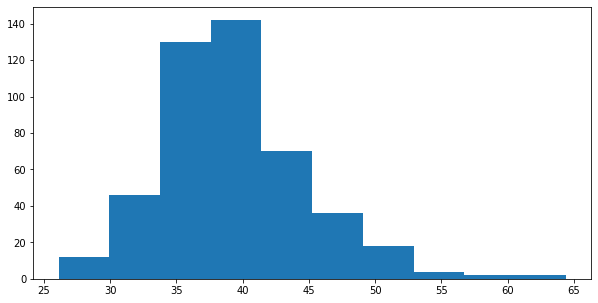

In [494]:
reference_WT_ingroup = []
for n in inlier_ref:
    for m in inlier_ref:
        br = branch_distance(refdictset[m],refdictset[n])
        if br > 1: reference_WT_ingroup.append(br)
#print(reference_WT_ingroup)
plt.hist(reference_WT_ingroup)
np.mean(reference_WT_ingroup),np.std(reference_WT_ingroup)

In [195]:
RNAi_size_assignments = dict()
RNAi_name_array = []
for n in range(0,len(fullnameset)):
    pad = fullnameset[n].split('/')[-1][:-14]
    #print(pad,n)
    RNAi_name_array.append(pad)
    if 'REFERENCE' in pad:
        if n in inlier_ref:
            pad = 'inlierWT'
        else: 
            pad = 'outlierWT'
    try:
        z = RNAi_size_assignments[pad]
        z.append(n)
    except:
        z = list()
        z.append(n)
        RNAi_size_assignments[pad] = z
        
RNAi_name_array = np.array(RNAi_name_array)
#RNAi_size_assignments['inlierWT'],RNAi_size_assignments['outlierWT']
RNAi_name_array[RNAi_size_assignments['inlierWT']] = 'inlierWT'
RNAi_name_array[RNAi_size_assignments['outlierWT']] = 'outlierWT'

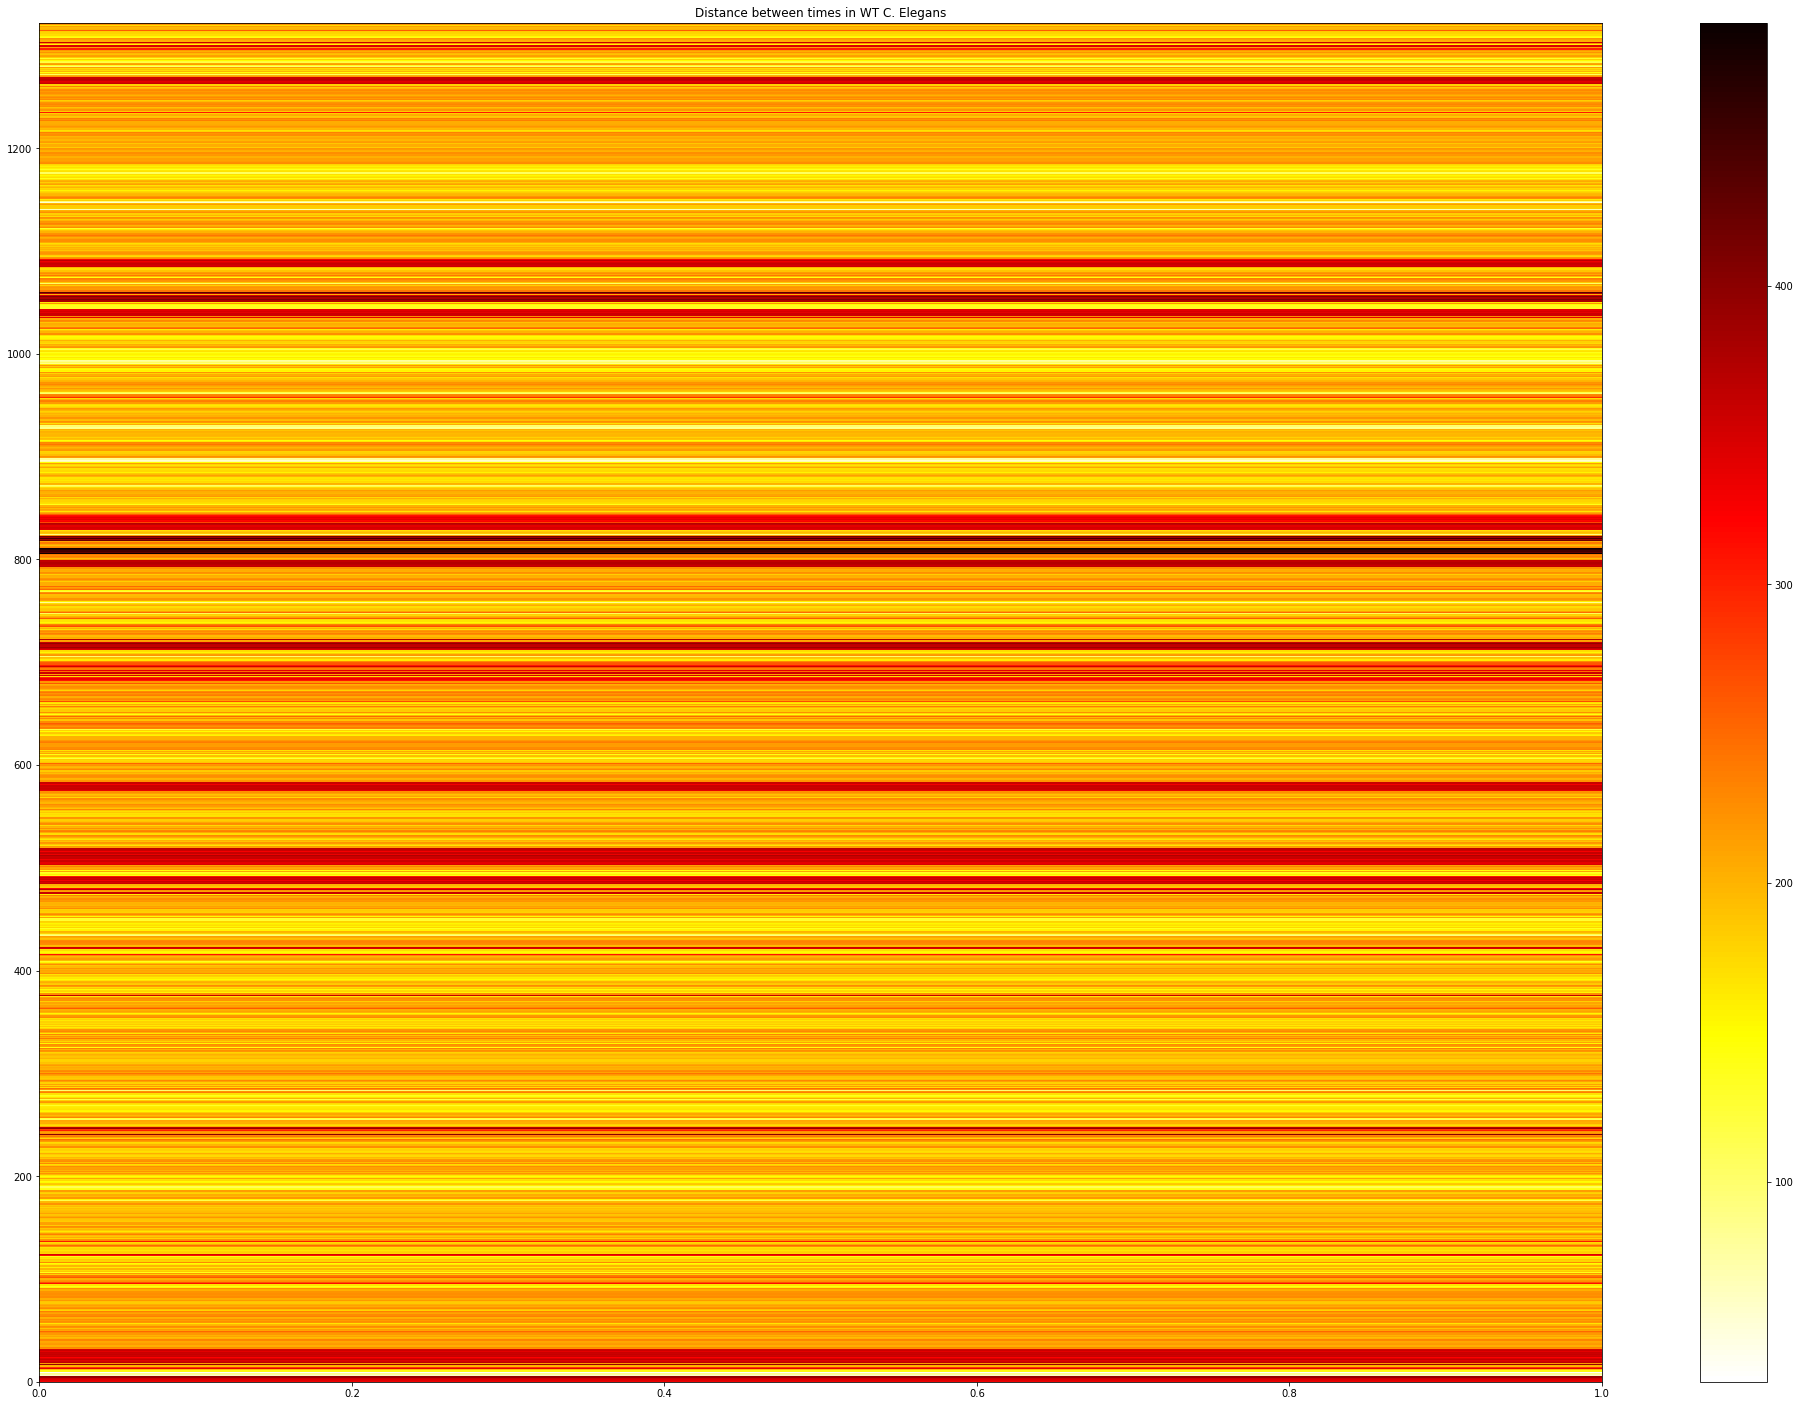

In [196]:
plot_2_examples(['hot_r'],np.mat(embryo_size_mat).T)

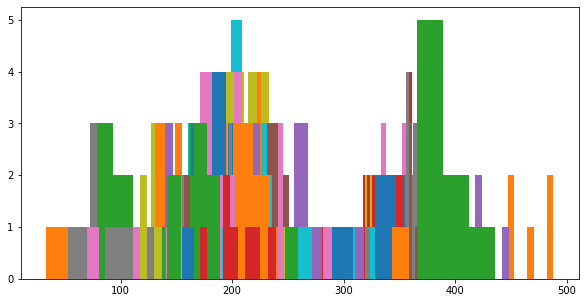

In [197]:
RNAi_embryo_size_list = []
size_full = np.array([])
#jaccard_full = np.concatenate((jaccard_full,comparisons), axis=None)
for n in list(RNAi_size_assignments)[2:]:
    size_groups = embryo_size_mat[0,(np.array(RNAi_size_assignments[n])-30)].flatten()
    size_groups = size_groups.tolist()[0]
    RNAi_embryo_size_list.append(size_groups)
    size_full = np.concatenate((size_full,np.array(size_groups)[:-6]), axis=None)
    plt.hist(size_groups)

(array([ 2.,  2., 25., 36., 36.,  4.,  1.,  6., 16.,  4.]),
 array([ 93. , 124.5, 156. , 187.5, 219. , 250.5, 282. , 313.5, 345. ,
        376.5, 408. ]),
 <BarContainer object of 10 artists>)

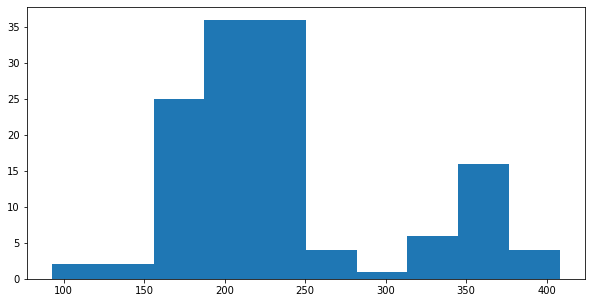

In [198]:
plt.hist(size_full)

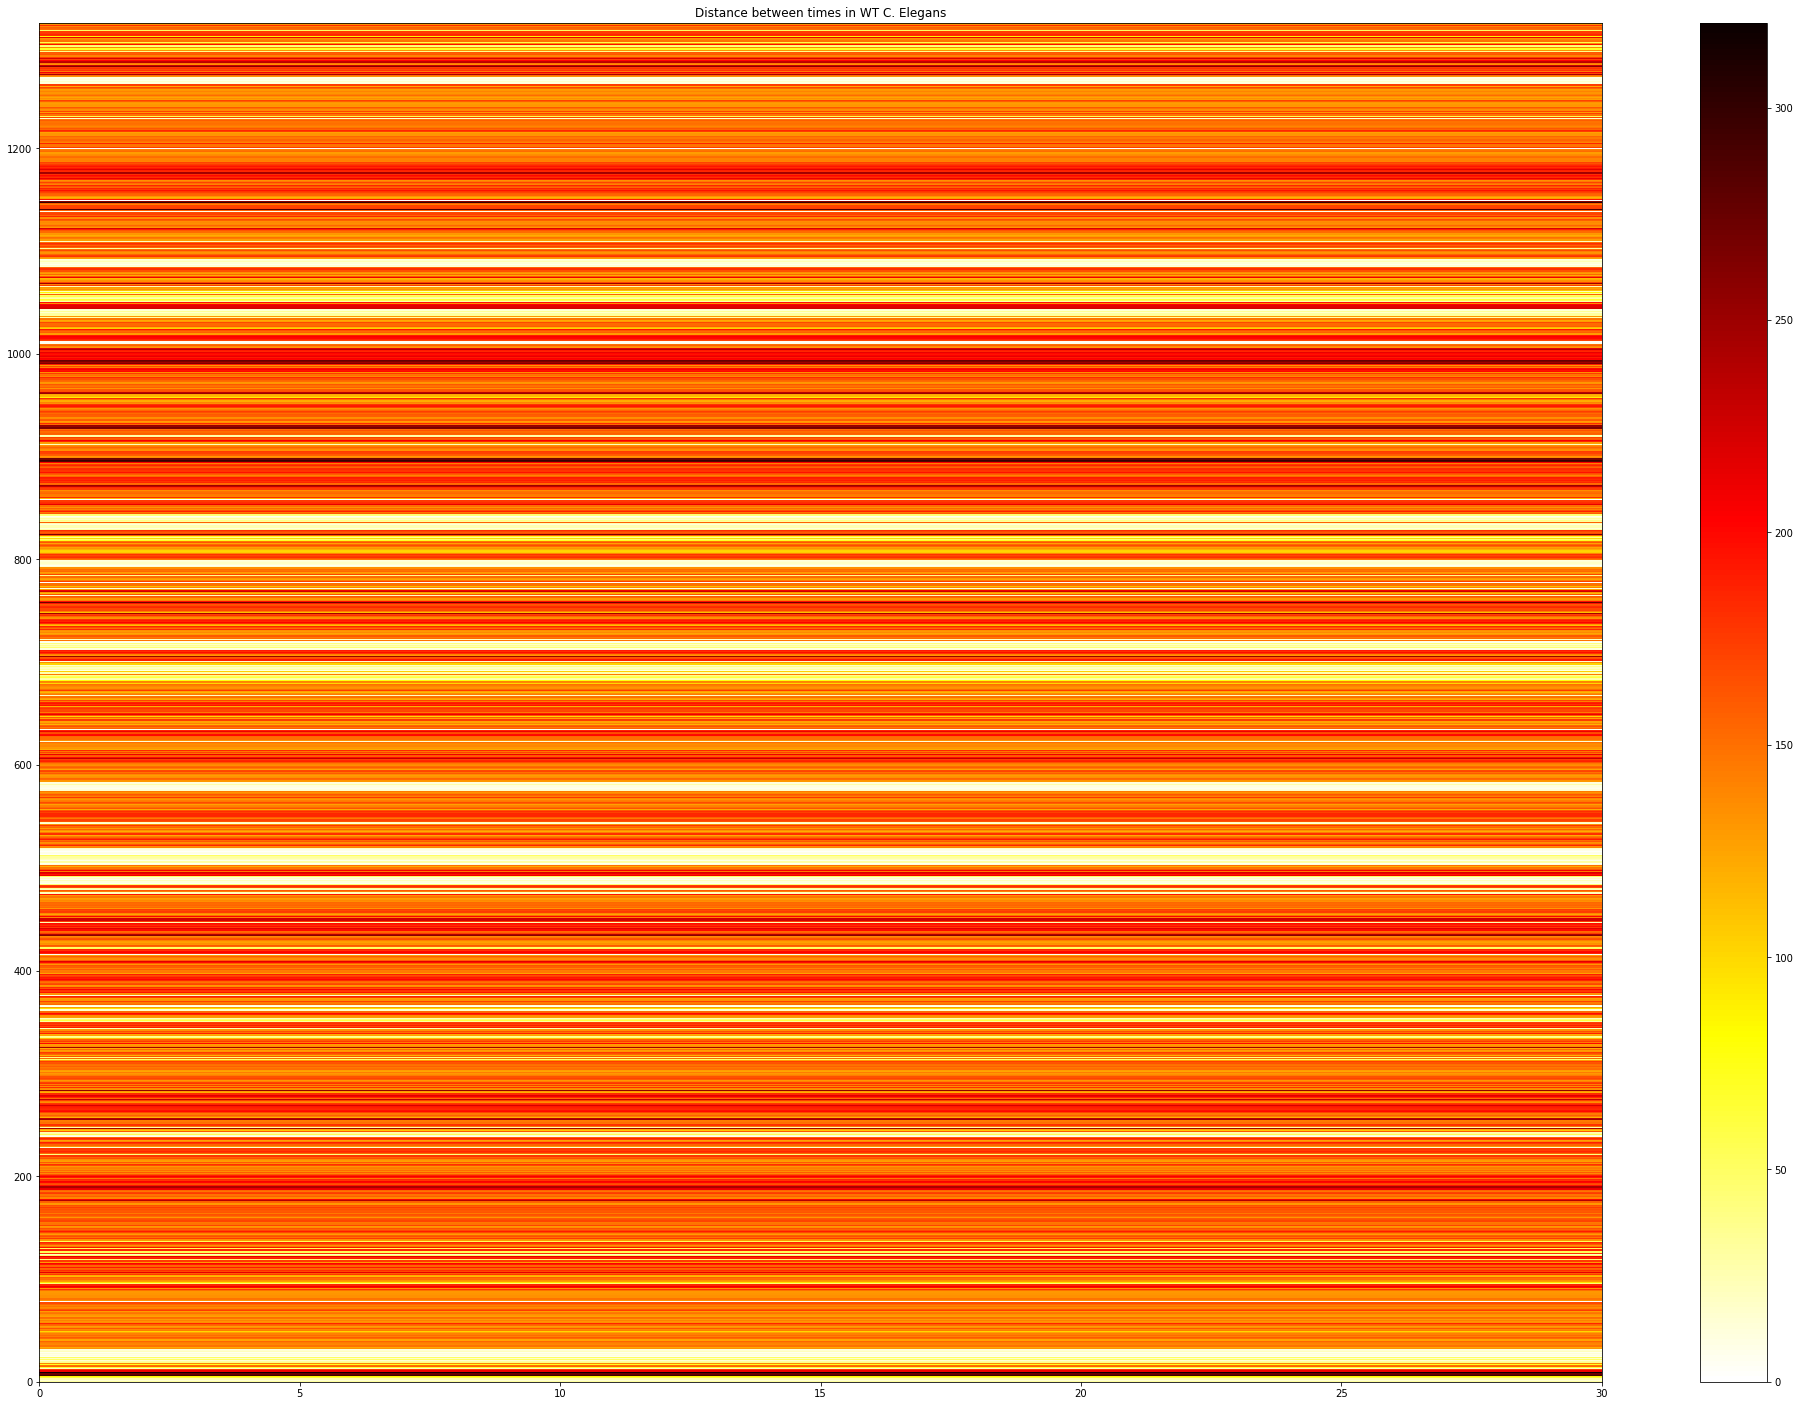

In [199]:
plot_2_examples(['hot_r'],np.mat(t_mat))

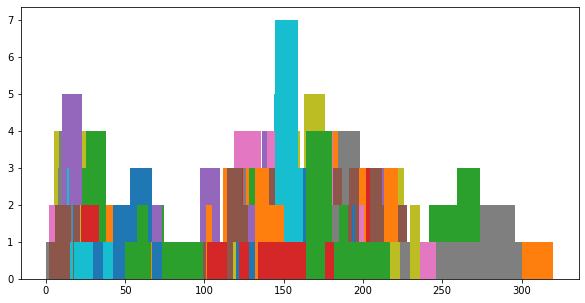

In [200]:
RNAi_WT_tree_distance_list = []
tree_full = np.array([])
#jaccard_full = np.concatenate((jaccard_full,comparisons), axis=None)
for n in list(RNAi_size_assignments)[2:]:
    tree_groups = t_mat[np.array(RNAi_size_assignments[n])-30,0].flatten()
    tree_groups = tree_groups.tolist()[0]
    RNAi_WT_tree_distance_list.append(tree_groups)
    tree_full = np.concatenate((tree_full,np.array(tree_groups)[:-6]), axis=None)
    plt.hist(tree_groups)

(array([28., 10.,  3.,  3., 18., 32., 31.,  4.,  2.,  1.]),
 array([  4. ,  29.6,  55.2,  80.8, 106.4, 132. , 157.6, 183.2, 208.8,
        234.4, 260. ]),
 <BarContainer object of 10 artists>)

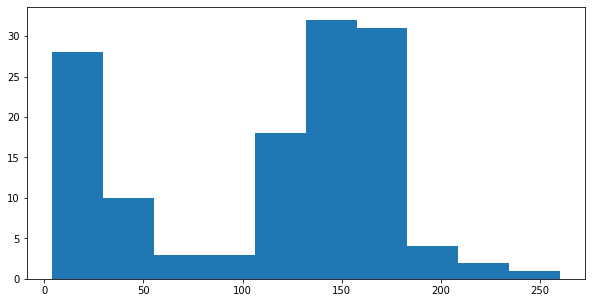

In [201]:
plt.hist(tree_full)

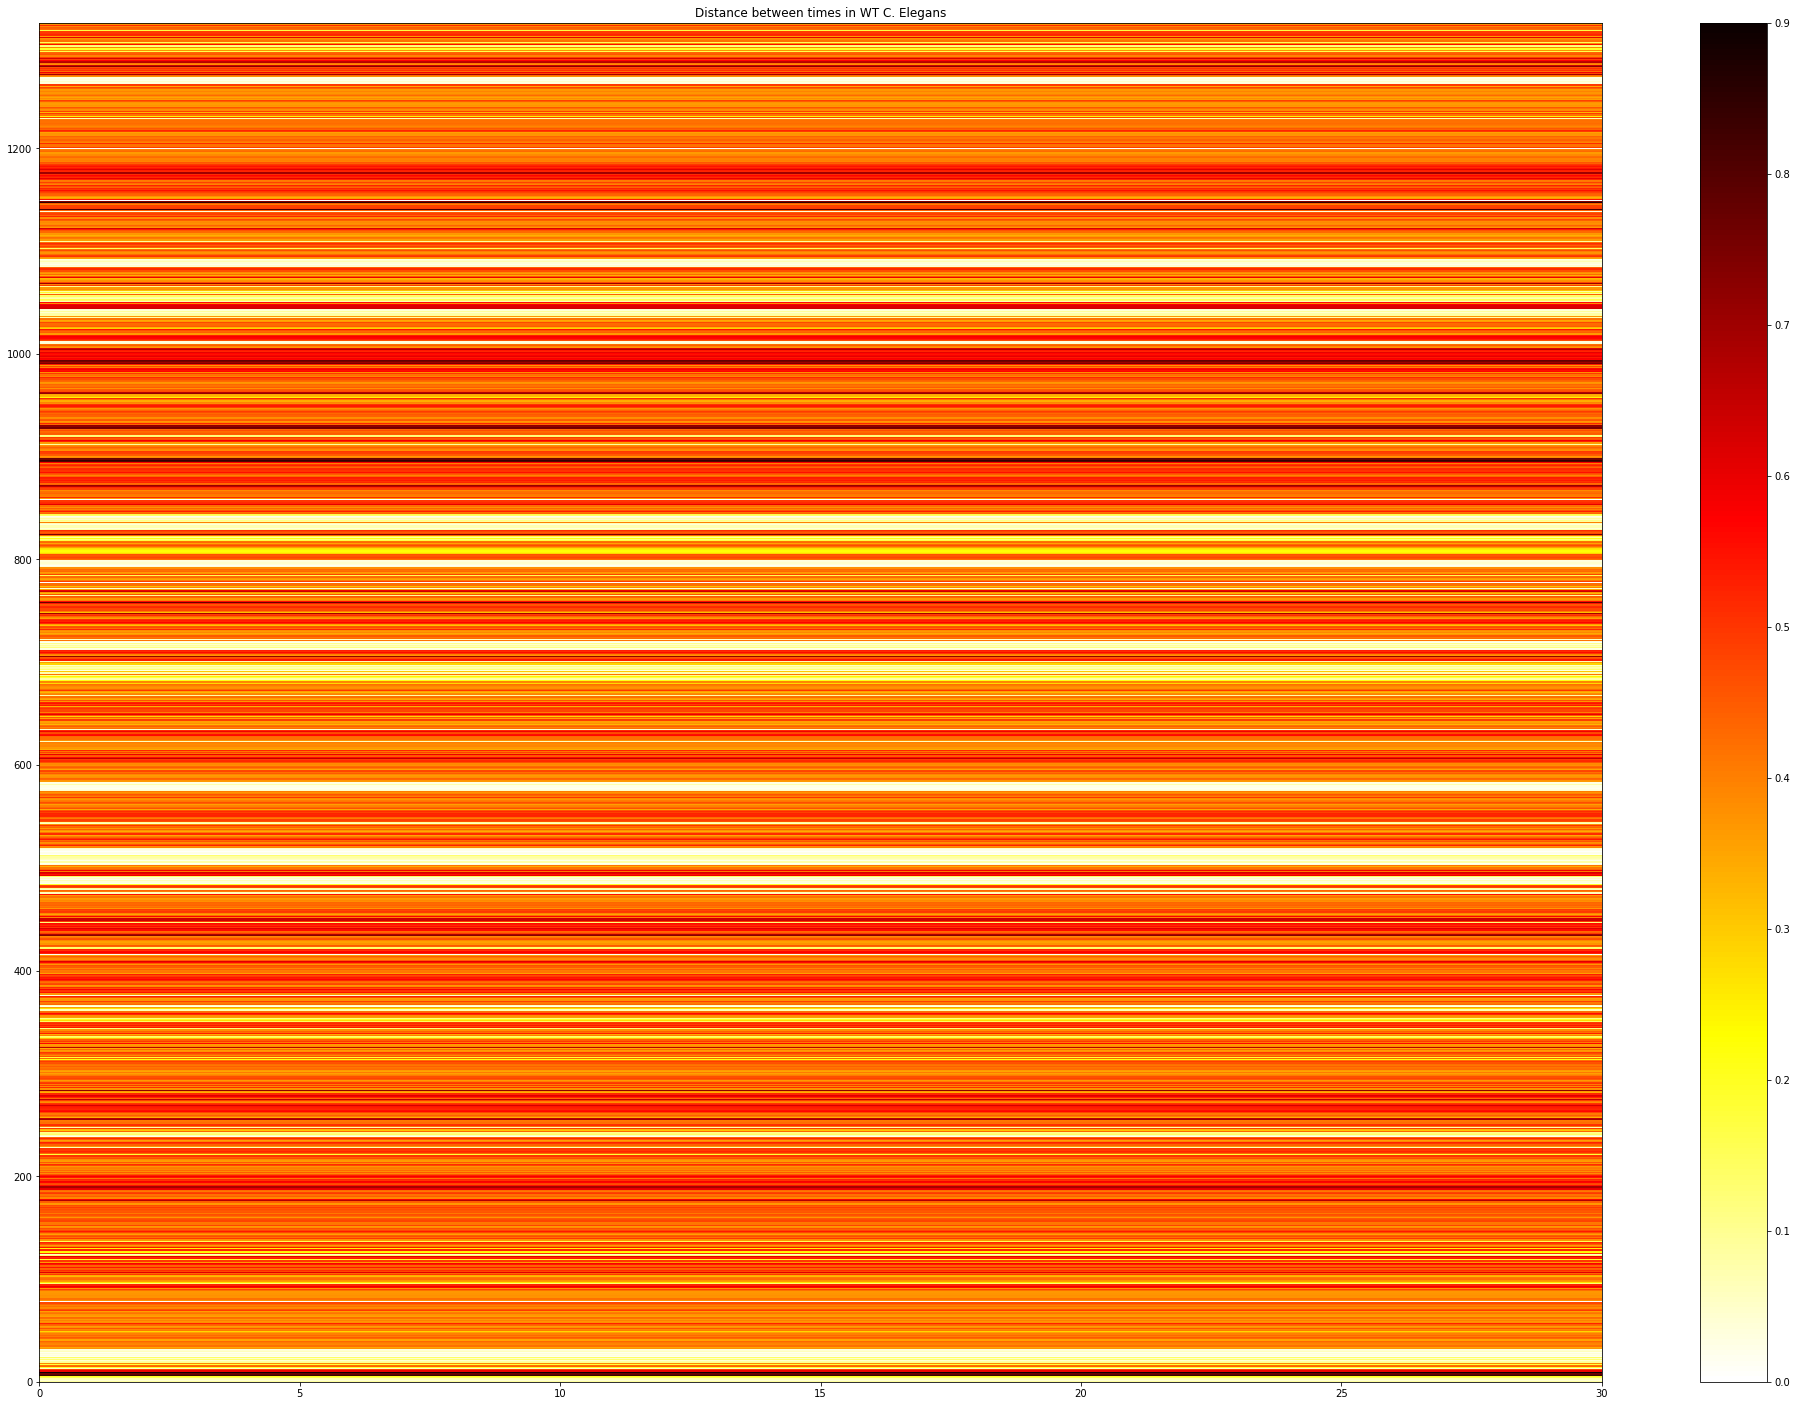

In [202]:
plot_2_examples(['hot_r'],np.mat(j_mat))

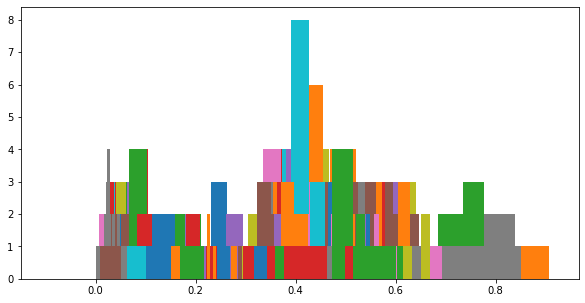

In [203]:
RNAi_WT_jaccard_distance_list = []
jaccard_full = np.array([])
#jaccard_full = np.concatenate((jaccard_full,comparisons), axis=None)
for n in list(RNAi_size_assignments)[2:]:
    jaccard_groups = j_mat[np.array(RNAi_size_assignments[n])-30,0].flatten()
    jaccard_groups = jaccard_groups.tolist()[0]
    RNAi_WT_jaccard_distance_list.append(jaccard_groups)
    jaccard_full = np.concatenate((jaccard_full,np.array(jaccard_groups)[:-6]), axis=None)
    plt.hist(jaccard_groups)

(array([26., 10.,  5.,  2., 21., 33., 28.,  4.,  2.,  1.]),
 array([0.01179941, 0.08427386, 0.15674831, 0.22922276, 0.30169721,
        0.37417166, 0.44664611, 0.51912056, 0.59159501, 0.66406946,
        0.73654391]),
 <BarContainer object of 10 artists>)

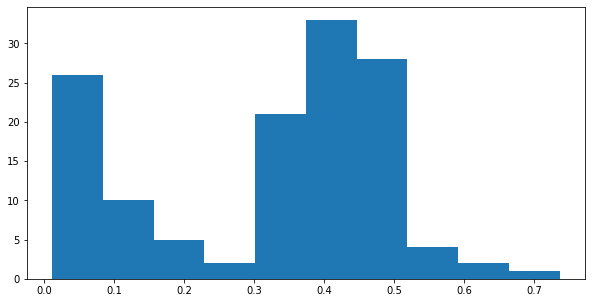

In [204]:
plt.hist(jaccard_full)

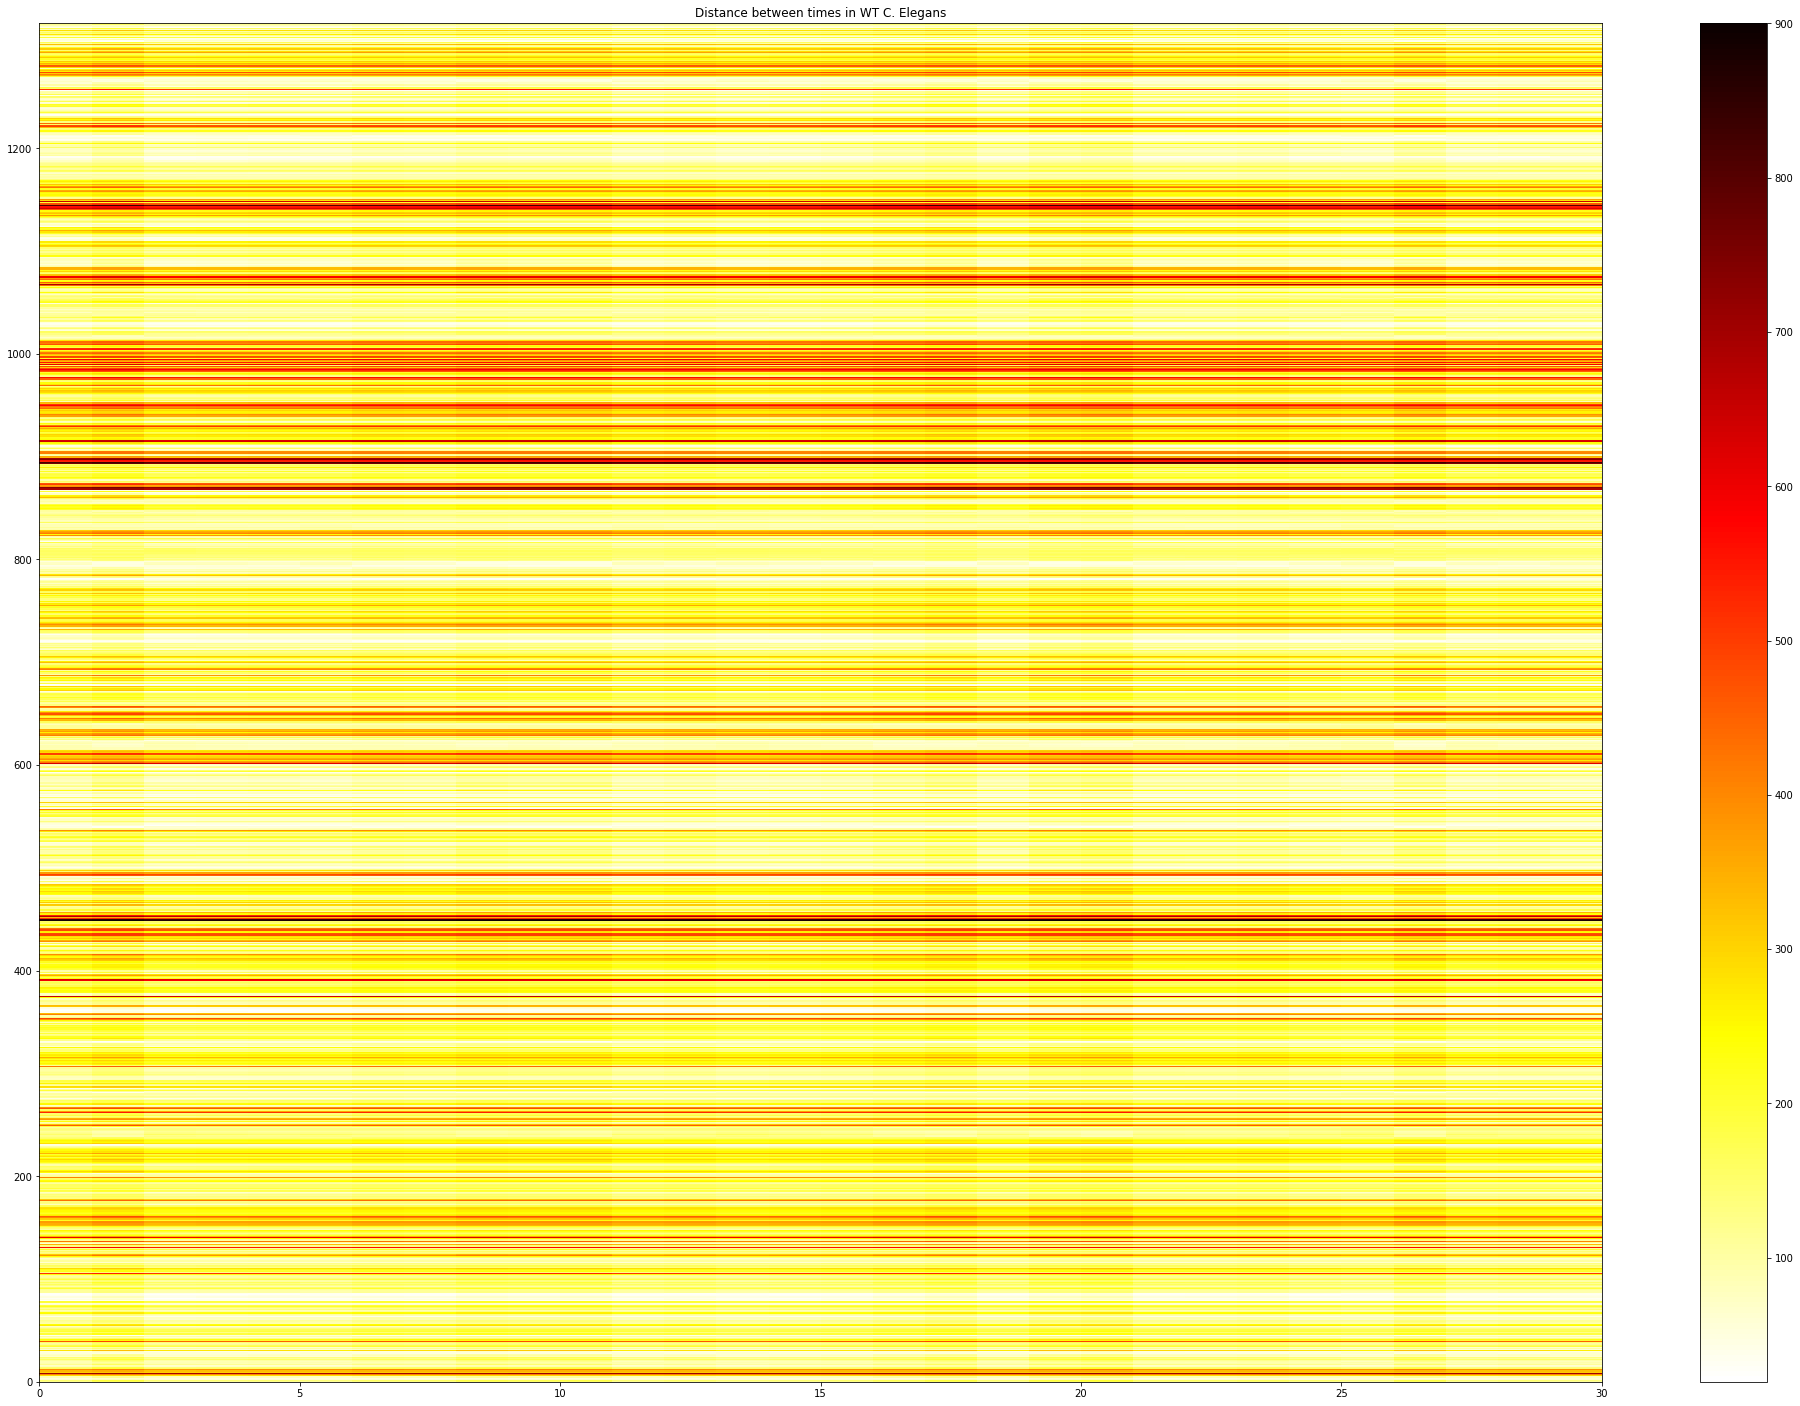

In [458]:
plot_2_examples(['hot_r'],np.mat(b_mat))

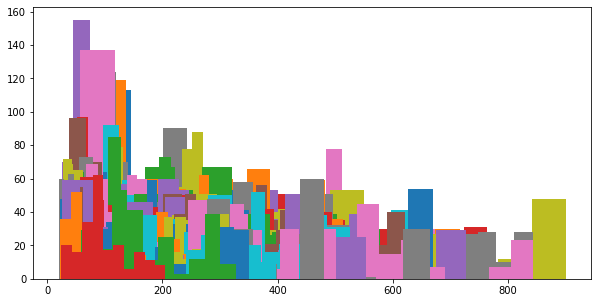

In [589]:
branch_full = np.array([])
#jaccard_full = np.concatenate((jaccard_full,comparisons), axis=None)
for n in list(RNAi_size_assignments)[2:]:
    #print(n)
    #print(n,np.array(RNAi_size_assignments[n])-30,t_mat[np.array(RNAi_size_assignments[n])-30,0])
    branch_groups = b_mat[np.array(RNAi_size_assignments[n])-30,:].flatten()
    branch_groups = branch_groups.tolist()[0]
    branch_full = np.concatenate((branch_full,np.array(branch_groups)[:-int(len(branch_groups)/1.05)]), axis=None)
    plt.hist(branch_groups)

(array([541., 625., 429., 157., 112.,  47.,  25.,  13.,   9.,   9.]),
 array([ 23.2594067 , 110.82923901, 198.39907132, 285.96890363,
        373.53873595, 461.10856826, 548.67840057, 636.24823288,
        723.81806519, 811.38789751, 898.95772982]),
 <BarContainer object of 10 artists>)

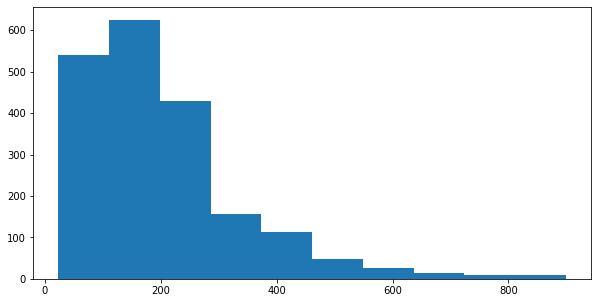

In [208]:
#branch_groups[:-int(len(branch_groups)/2)]
plt.hist(branch_full )

 #.flatten().tolist()

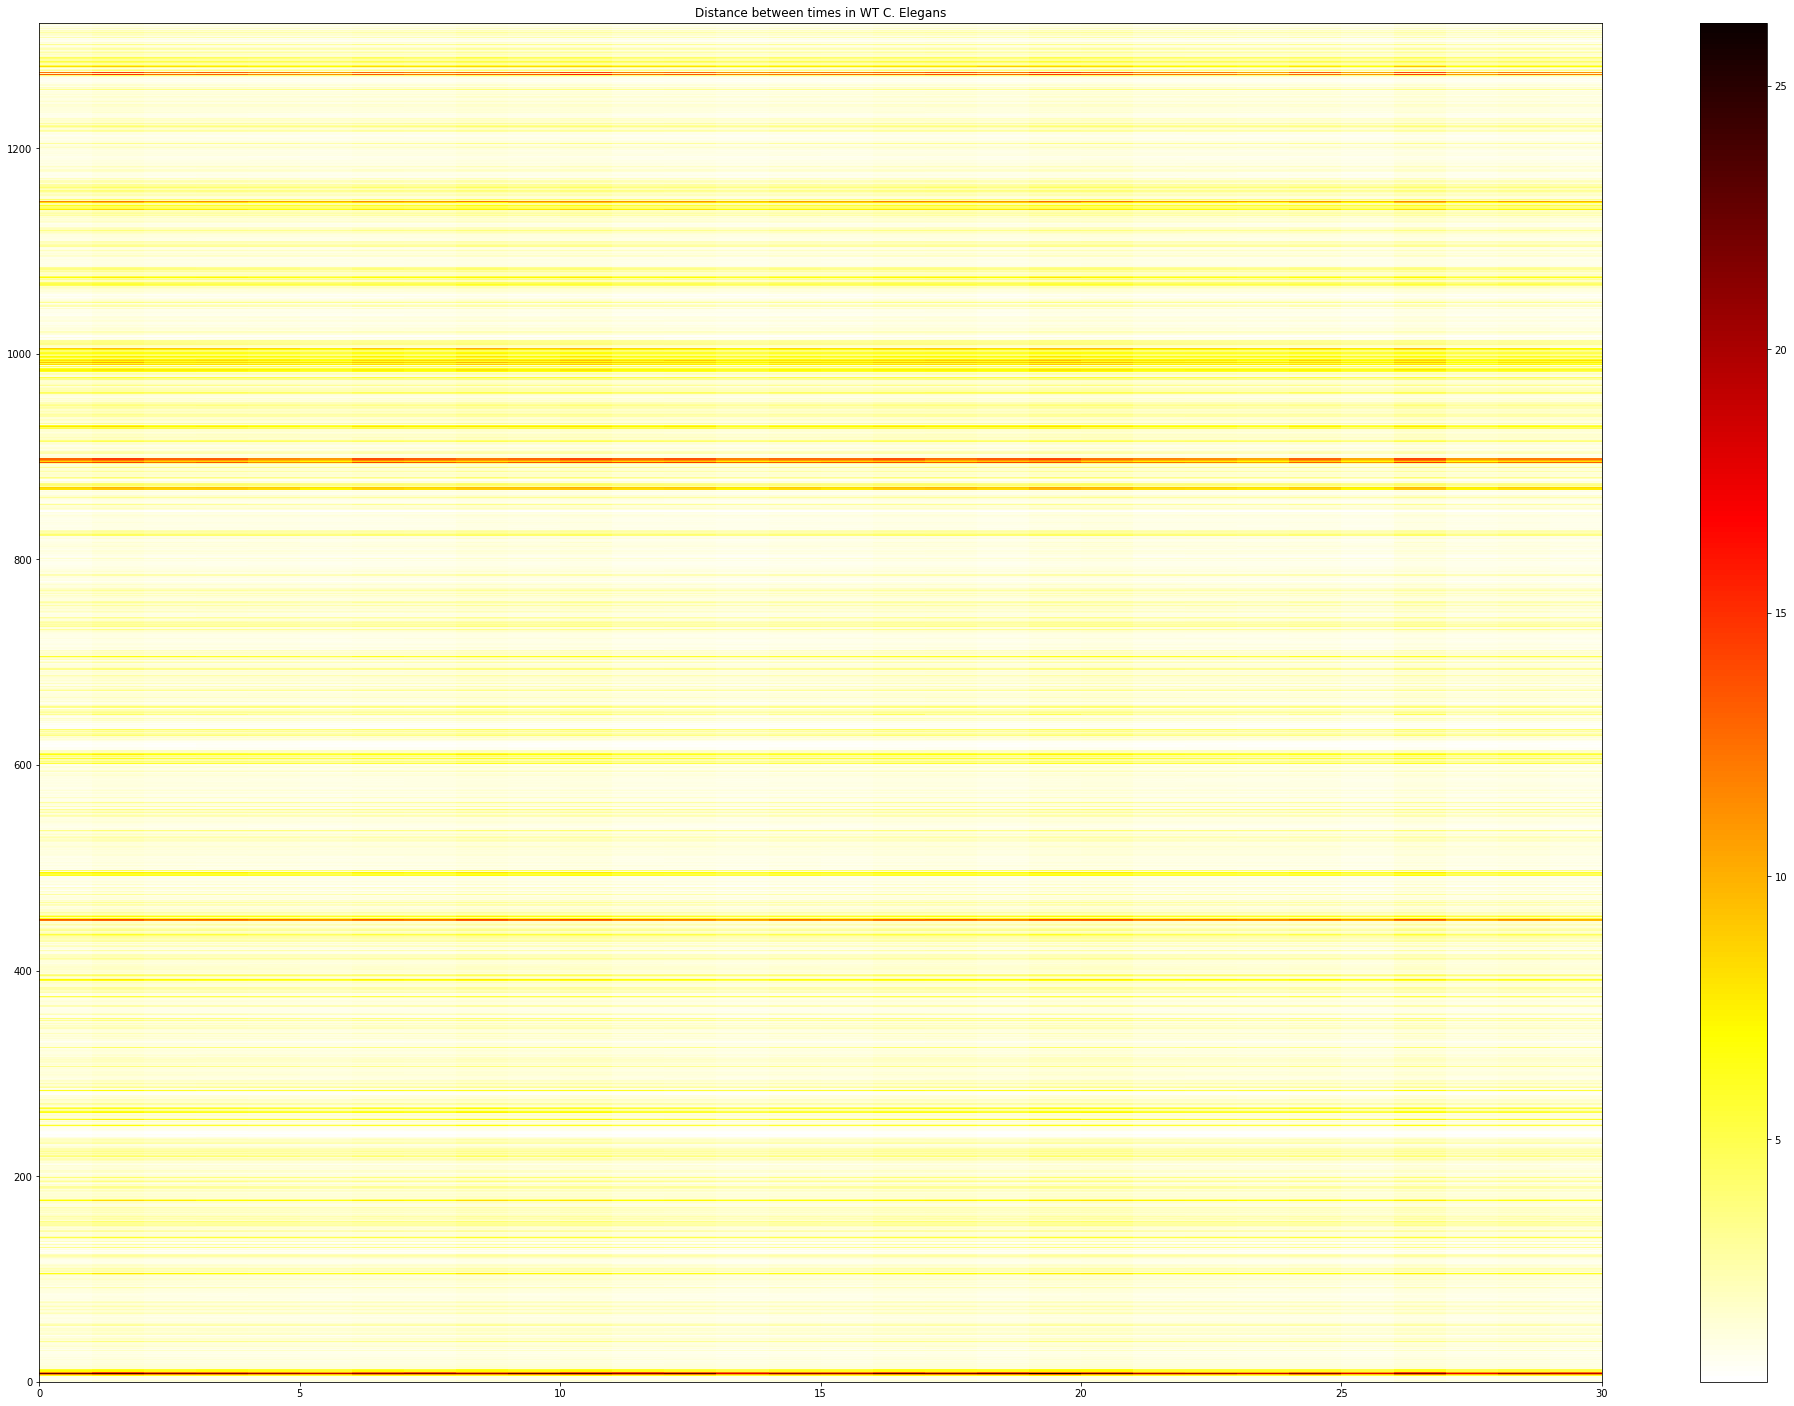

In [209]:
plot_2_examples(['hot_r'],np.mat(PCA_mat))

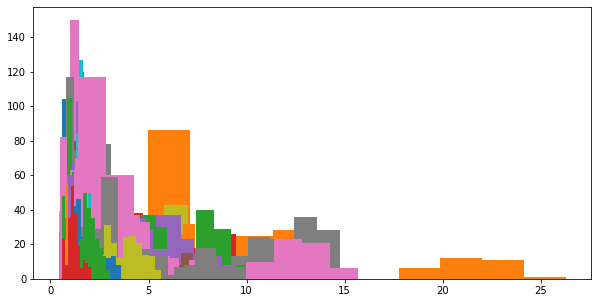

In [210]:
RNAi_WT_PCA_distance_list =[]
PCA_full = np.array([])
#jaccard_full = np.concatenate((jaccard_full,comparisons), axis=None)
for n in list(RNAi_size_assignments)[2:]:
    #print(n)
    #print(n,np.array(RNAi_size_assignments[n])-30,t_mat[np.array(RNAi_size_assignments[n])-30,0])
    PCA_groups = PCA_mat[np.array(RNAi_size_assignments[n])-30,:].flatten()
    PCA_groups = PCA_groups.tolist()[0]
    PCA_full = np.concatenate((PCA_full,np.array(PCA_groups)[:-int(len(PCA_groups)/1.05)]), axis=None)
    RNAi_WT_PCA_distance_list.append(PCA_groups)
    plt.hist(PCA_groups)

(array([1216.,  487.,  142.,   25.,   57.,   22.,    9.,    0.,    6.,
           3.]),
 array([ 0.52379036,  1.77210816,  3.02042596,  4.26874376,  5.51706156,
         6.76537936,  8.01369716,  9.26201496, 10.51033276, 11.75865057,
        13.00696837]),
 <BarContainer object of 10 artists>)

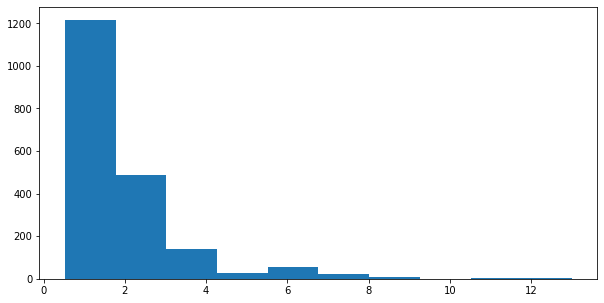

In [211]:
plt.hist(PCA_full)

In [213]:
RNAi_name_assignments_kinda = list(RNAi_size_assignments)[2:]
RNAi_WT_branch_means_list =[];RNAi_WT_branch_std_list =[]
RNAi_WT_tree_means_list =[];RNAi_WT_tree_std_list =[]
RNAi_WT_jaccard_means_list =[];RNAi_WT_jaccard_std_list =[]
RNAi_WT_PCA_means_list =[];RNAi_WT_PCA_std_list =[]
RNAi_size_means_list=[];RNAi_size_std_list =[]
b2_mat = np.mat(b_mat).T[inlier_ref].T


Gene_ranking_list = []
#jaccard_full = np.concatenate((jaccard_full,comparisons), axis=None)
for n in list(RNAi_size_assignments)[2:]:
    #print(n)
    #print(n,np.array(RNAi_size_assignments[n])-30,t_mat[np.array(RNAi_size_assignments[n])-30,0])
    branch_groups = b2_mat[np.array(RNAi_size_assignments[n])-30,:].flatten()
    branch_groups = branch_groups.tolist()[0]
    jaccard_groups = j_mat[np.array(RNAi_size_assignments[n])-30,0].flatten() * 100
    jaccard_groups = jaccard_groups.tolist()[0]
    PCA_groups = PCA_mat[np.array(RNAi_size_assignments[n])-30,:].flatten()
    PCA_groups = PCA_groups.tolist()[0]
    #print(n, PCA_groups)
    tree_groups = t_mat[np.array(RNAi_size_assignments[n])-30,0].flatten()
    tree_groups = tree_groups.tolist()[0]
    size_groups = embryo_size_mat[0,(np.array(RNAi_size_assignments[n])-30)].flatten()
    size_groups = size_groups.tolist()[0]
    RNAi_WT_branch_means_list.append(np.mean(branch_groups));RNAi_WT_branch_std_list.append(np.std(branch_groups))
    RNAi_WT_jaccard_means_list.append(np.mean(jaccard_groups));RNAi_WT_jaccard_std_list.append(np.std(jaccard_groups ))
    RNAi_WT_PCA_means_list.append(np.mean(PCA_groups ));RNAi_WT_PCA_std_list.append(np.std(PCA_groups ))
    RNAi_WT_tree_means_list.append(np.mean(tree_groups ));RNAi_WT_tree_std_list.append(np.std(tree_groups ))
    RNAi_size_means_list.append(np.mean(size_groups));RNAi_size_std_list.append(np.std(size_groups))
    ranking_tuple = (n,np.mean(tree_groups ), np.mean(jaccard_groups),np.mean(branch_groups),np.mean(PCA_groups ), np.mean(size_groups))
    #print(ranking_tuple)
    Gene_ranking_list.append(ranking_tuple)
    #plt.hist(branch_groups)

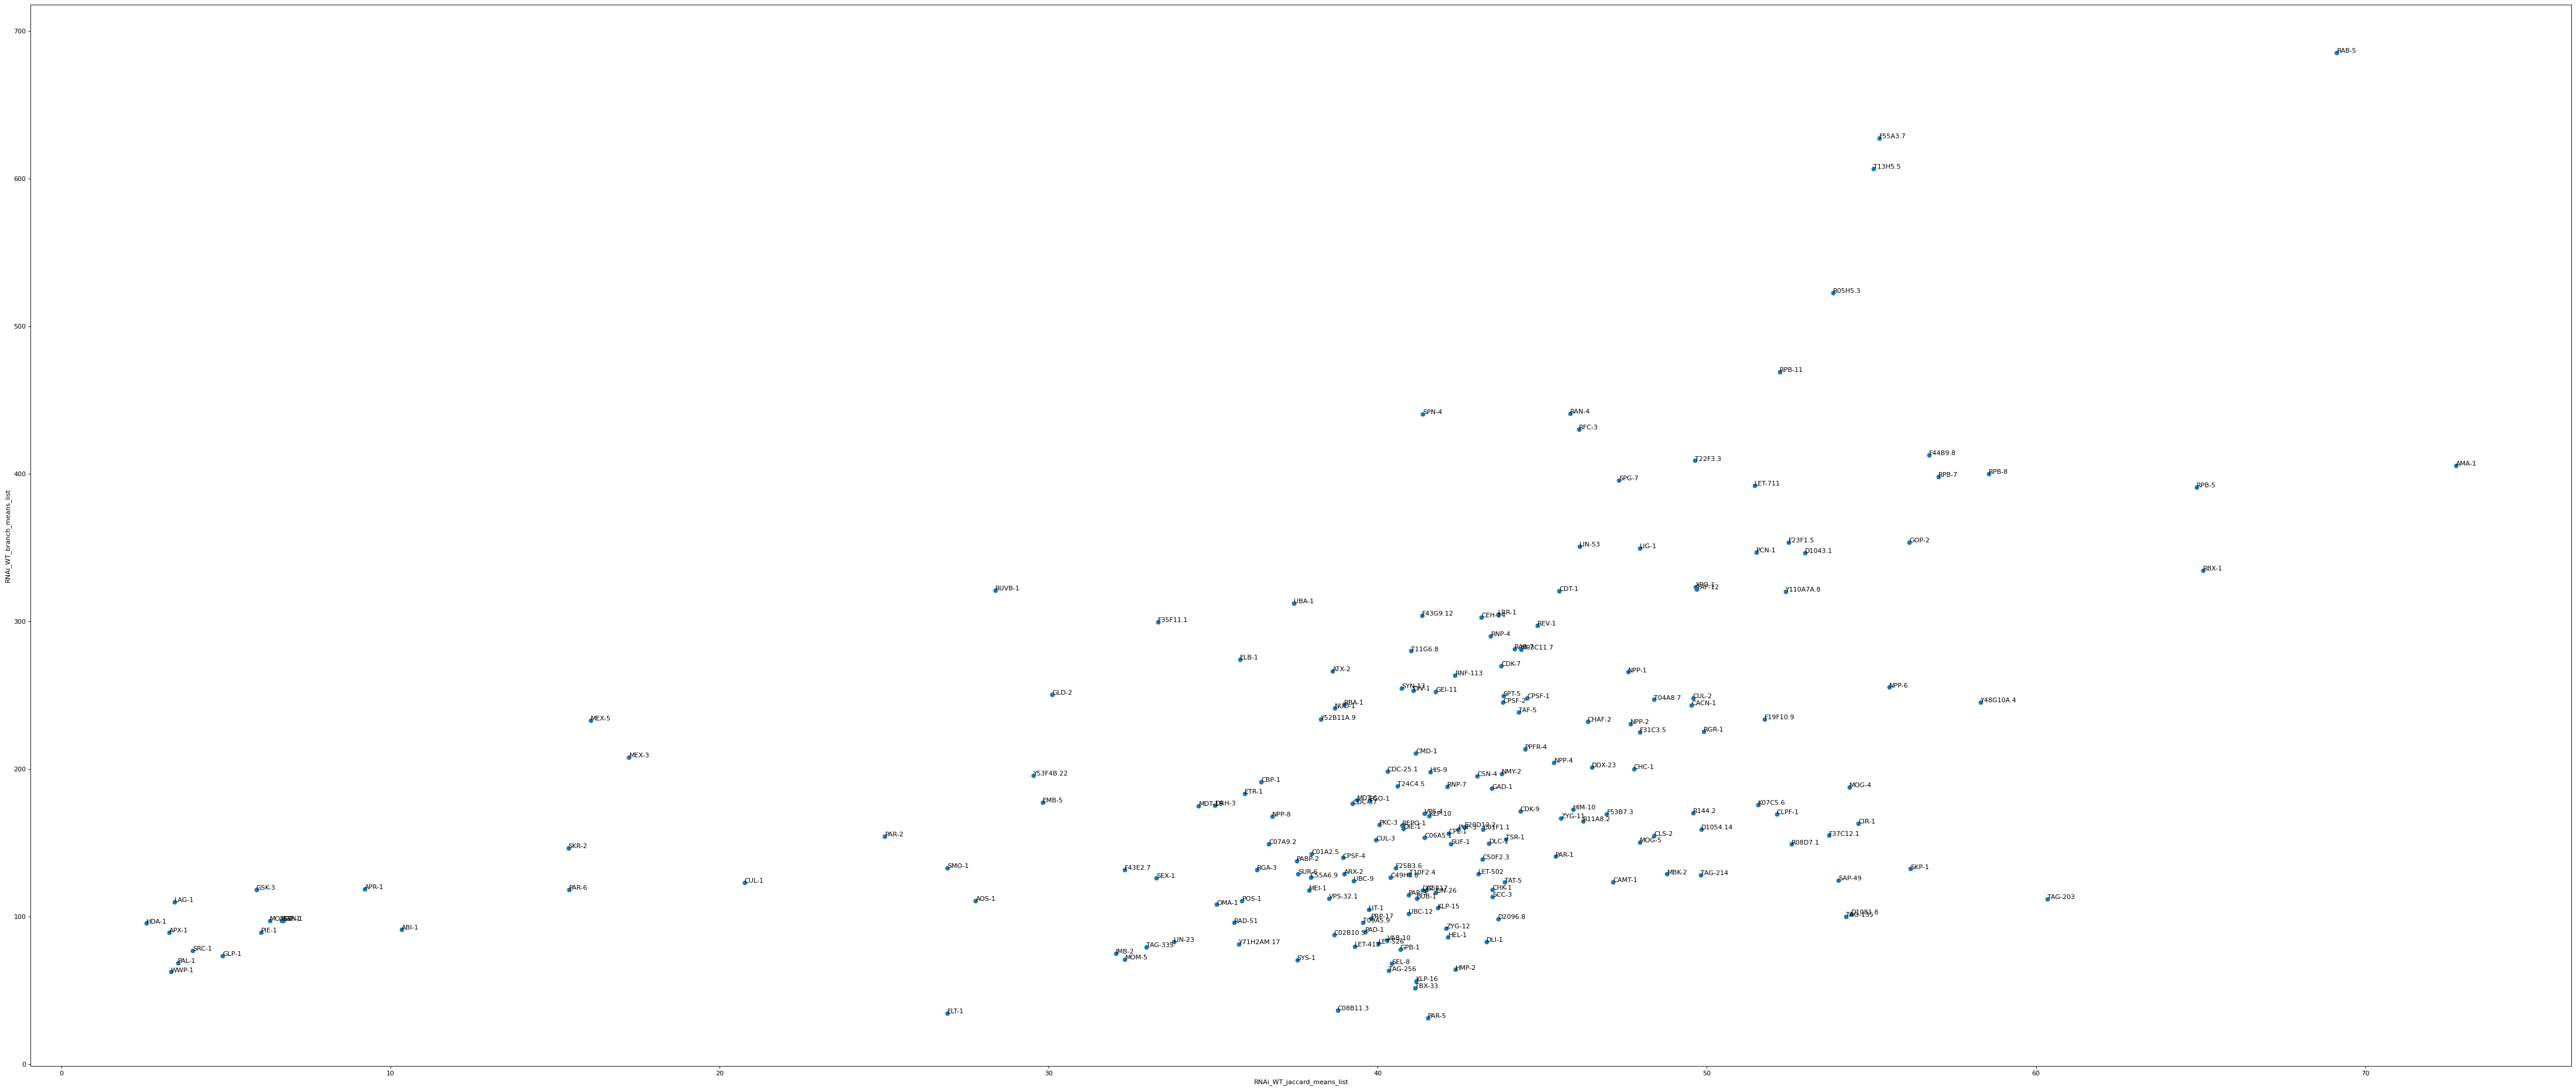

In [215]:
plt.figure(figsize=(70, 30), dpi=80)
plt.scatter(RNAi_WT_jaccard_means_list,RNAi_WT_branch_means_list)
plt.xlabel('RNAi_WT_jaccard_means_list')
plt.ylabel('RNAi_WT_branch_means_list')
for i, txt in enumerate(RNAi_name_assignments_kinda):
    plt.annotate(txt, (RNAi_WT_jaccard_means_list[i],RNAi_WT_branch_means_list[i]))

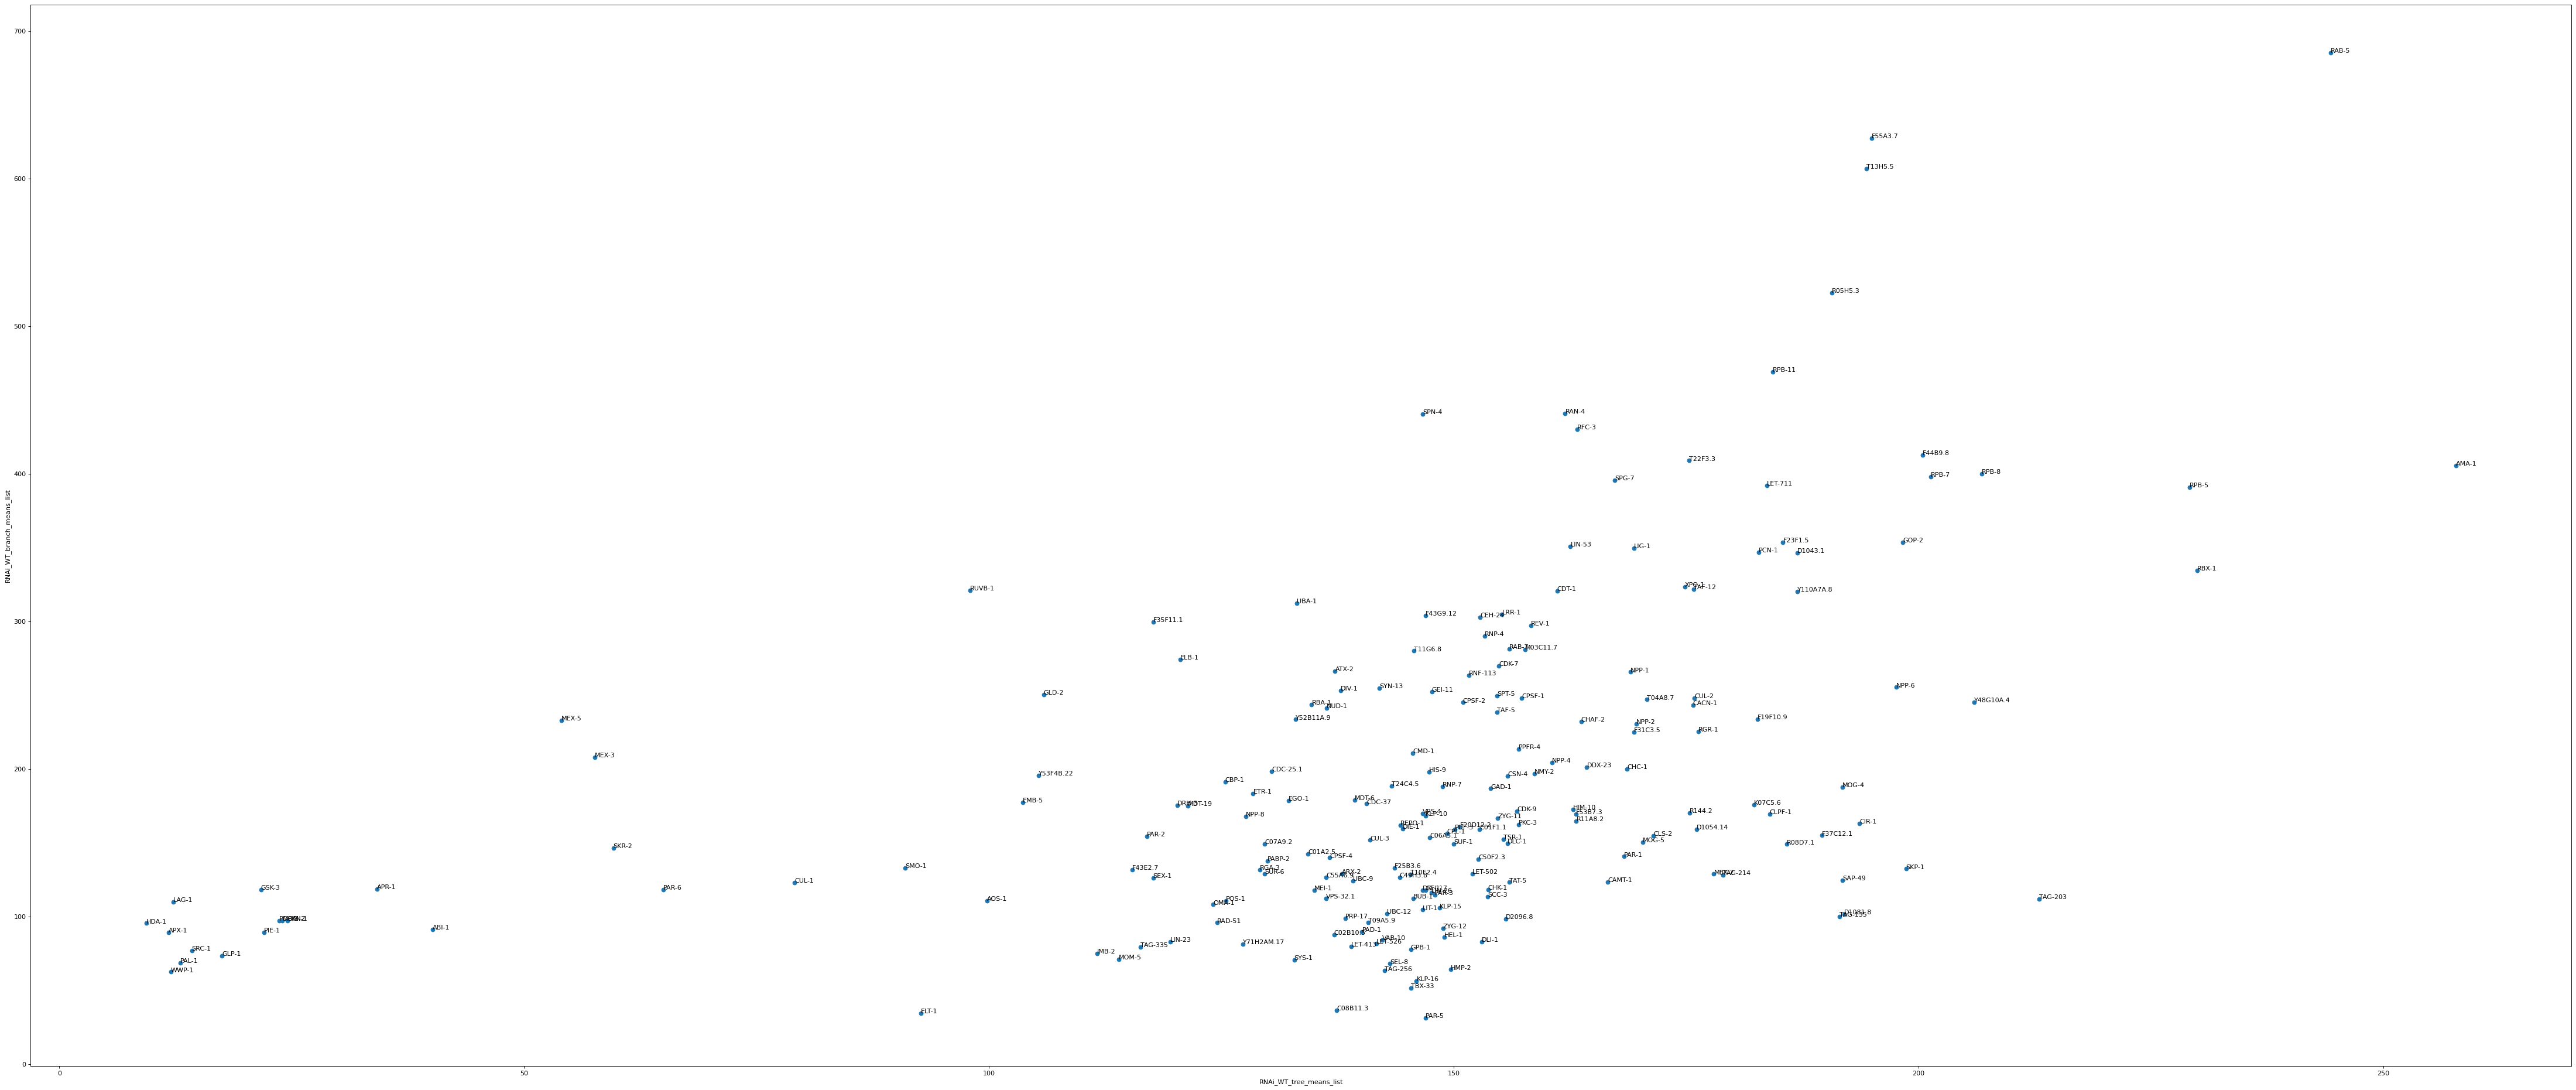

In [312]:
plt.figure(figsize=(70, 30), dpi=80)
plt.scatter(RNAi_WT_tree_means_list,RNAi_WT_branch_means_list)
plt.xlabel('RNAi_WT_tree_means_list')
plt.ylabel('RNAi_WT_branch_means_list')
for i, txt in enumerate(RNAi_name_assignments_kinda):
    plt.annotate(txt, (RNAi_WT_tree_means_list[i],RNAi_WT_branch_means_list[i]))

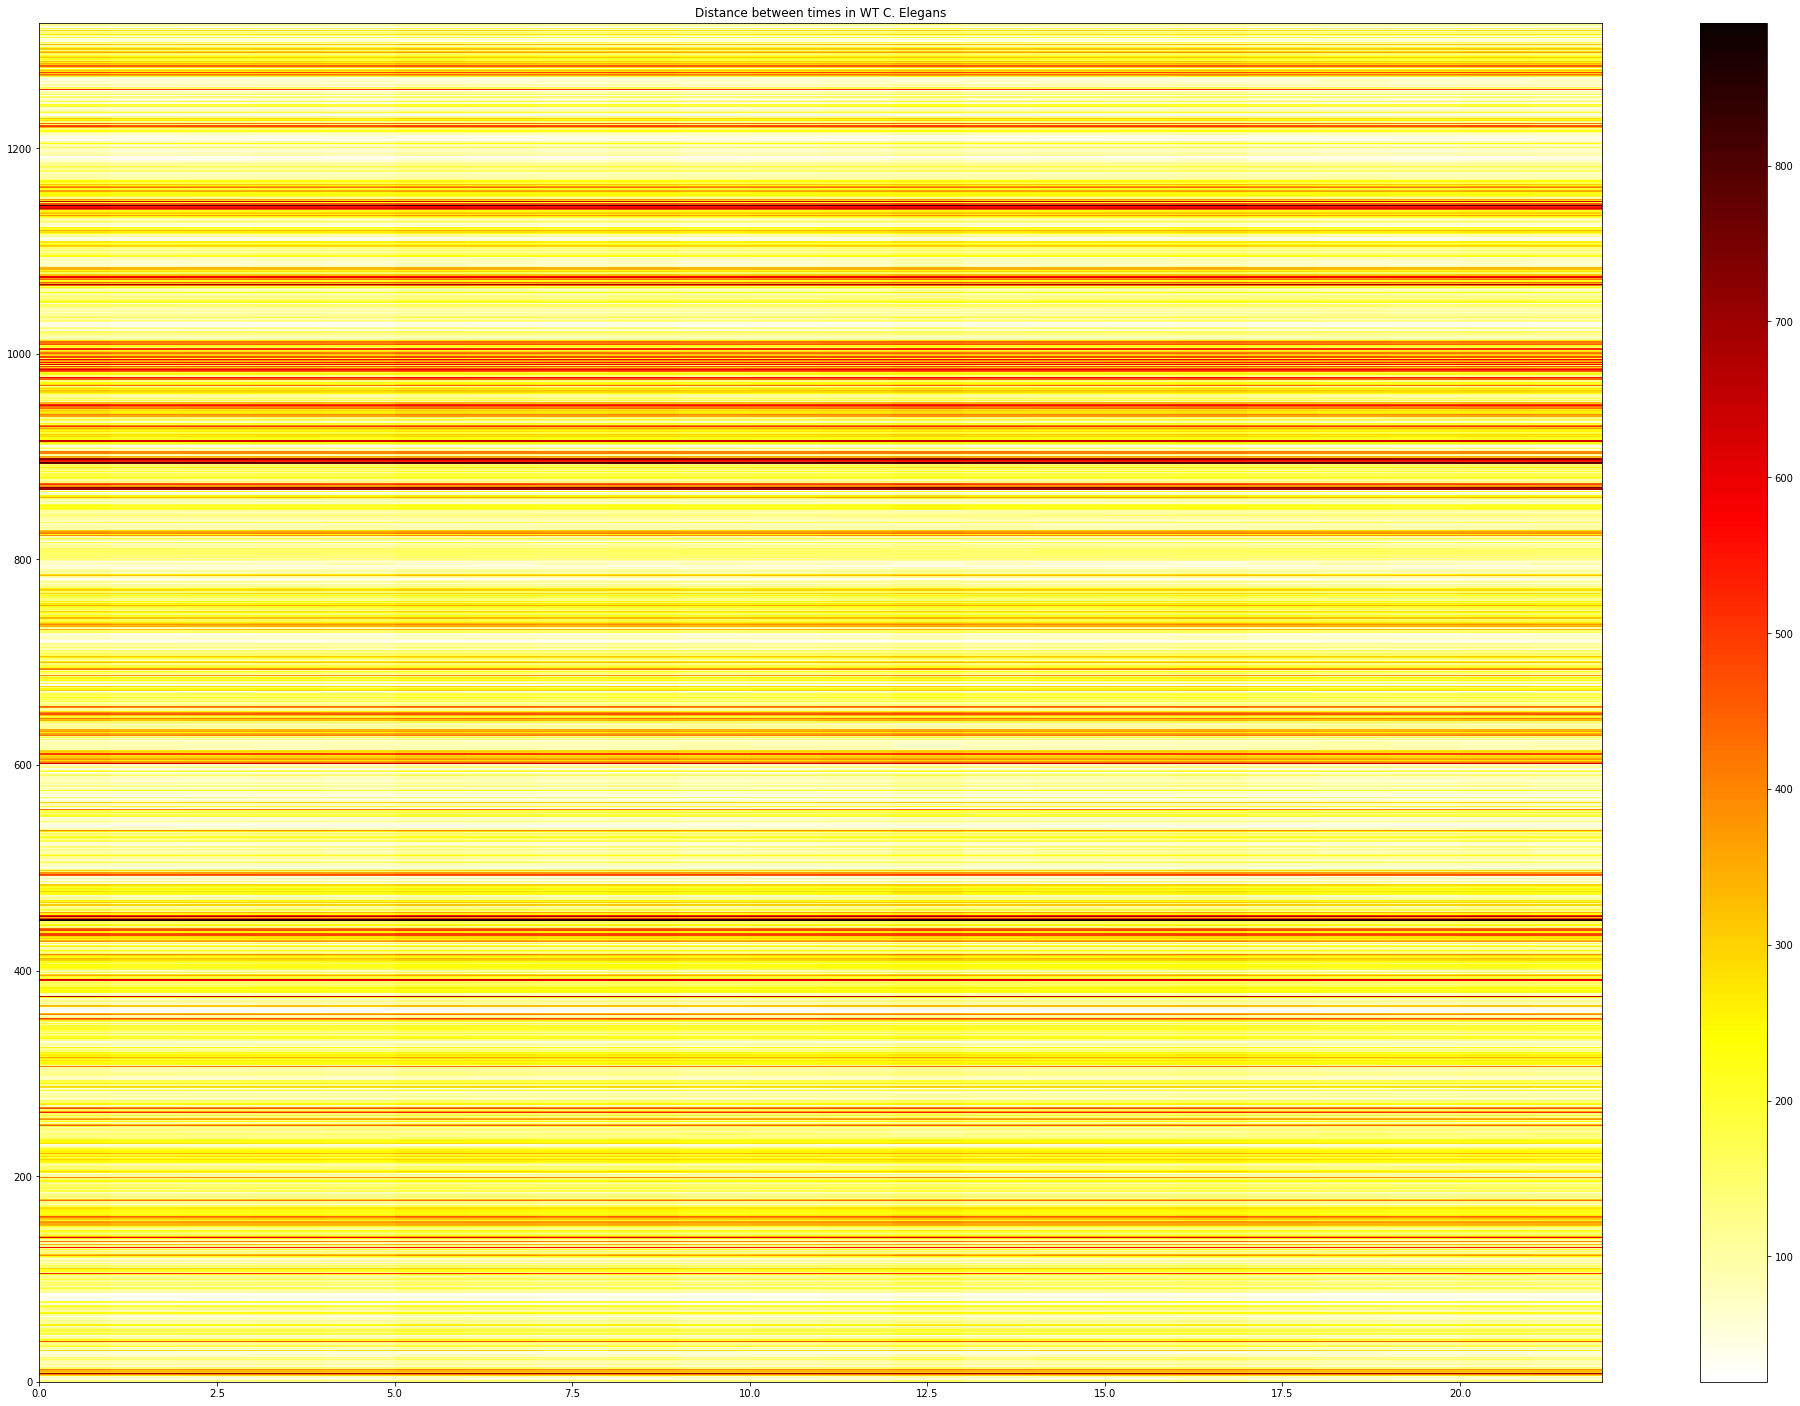

In [462]:
b2_mat = np.mat(b_mat).T[inlier_ref].T
plot_2_examples(['hot_r'],b2_mat)

In [525]:
np.array(np.where(RNAi_name_array == 'APR-1')) - 30

array([[18, 19, 20, 21, 22, 23]])

In [526]:
set(RNAi_name_array)

{'ABI-1',
 'AMA-1',
 'AOS-1',
 'APR-1',
 'APX-1',
 'ARX-2',
 'ATX-2',
 'BUB-1',
 'C01A2.5',
 'C01F1.1',
 'C02B10.5',
 'C06A5.1',
 'C07A9.2',
 'C08B11.3',
 'C49H3.8',
 'C50F2.3',
 'C55A6.9',
 'CACN-1',
 'CAMT-1',
 'CBP-1',
 'CDC-25.1',
 'CDC-37',
 'CDK-7',
 'CDK-9',
 'CDT-1',
 'CEH-24',
 'CHAF-2',
 'CHC-1',
 'CHK-1',
 'CIR-1',
 'CLPF-1',
 'CLS-2',
 'CMD-1',
 'CPL-1',
 'CPSF-1',
 'CPSF-2',
 'CPSF-4',
 'CSN-4',
 'CUL-1',
 'CUL-2',
 'CUL-3',
 'D1043.1',
 'D1054.14',
 'D1081.8',
 'D2096.8',
 'DDX-23',
 'DIC-1',
 'DIE-1',
 'DIV-1',
 'DLC-1',
 'DLI-1',
 'DRH-3',
 'EGO-1',
 'ELB-1',
 'ELT-1',
 'EMB-5',
 'ETR-1',
 'F19F10.9',
 'F20D12.2',
 'F23F1.5',
 'F25B3.6',
 'F31C3.5',
 'F35F11.1',
 'F37C12.1',
 'F43E2.7',
 'F43G9.12',
 'F44B9.8',
 'F53B7.3',
 'F55A3.7',
 'GAD-1',
 'GEI-11',
 'GEI-17',
 'GLD-2',
 'GLP-1',
 'GOP-2',
 'GPB-1',
 'GSK-3',
 'HDA-1',
 'HEL-1',
 'HIM-10',
 'HIS-9',
 'HMP-2',
 'IMB-2',
 'K07C5.6',
 'KLP-10',
 'KLP-15',
 'KLP-16',
 'LAG-1',
 'LET-413',
 'LET-502',
 'LET-526',
 'LET

In [527]:
#plot_2_examples(['hot_r'],np.mat(b2_mat)[0:4])

In [528]:
#np.matrix(b2_mat[np.array(np.where(RNAi_name_array == 'ABI-1')) - 30])

In [529]:
#plot_2_examples(['hot_r'],np.matrix(b2_mat[np.array(np.where(RNAi_name_array == 'ABI-1')) - 30]))

In [548]:
temp_b_mat = b2_mat[np.array(np.where(RNAi_name_array == 'ATX-2')) - 30][0]

In [549]:
#RNAi_indices = [np.array(np.where(RNAi_name_array == 'ABI-1')) - 30][0].tolist()[0]

In [560]:
for n in RNAi_indices:
    for m in RNAi_indices:
        print(n,m , branch_distance(fulldictset[n],fulldictset[m]))

0 0 0.0
0 1 60.56401571890688
0 2 37.603191353926334
0 3 37.76241517699841
0 4 37.49666651850535
0 5 37.22902093797257
1 0 60.56401571890688
1 1 0.0
1 2 70.01428425685718
1 3 71.20393247567159
1 4 64.96152707564686
1 5 76.4591394144611
2 0 37.603191353926334
2 1 70.01428425685718
2 2 0.0
2 3 33.1058907144937
2 4 34.55430508634199
2 5 37.68288736283355
3 0 37.76241517699841
3 1 71.20393247567159
3 2 33.1058907144937
3 3 0.0
3 4 33.91164991562634
3 5 36.41428291206625
4 0 37.49666651850535
4 1 64.96152707564686
4 2 34.55430508634199
4 3 33.91164991562634
4 4 0.0
4 5 36.55133376499413
5 0 37.22902093797257
5 1 76.4591394144611
5 2 37.68288736283355
5 3 36.41428291206625
5 4 36.55133376499413
5 5 0.0


In [553]:
#plot_2_examples(['hot_r'],temp_b_mat)

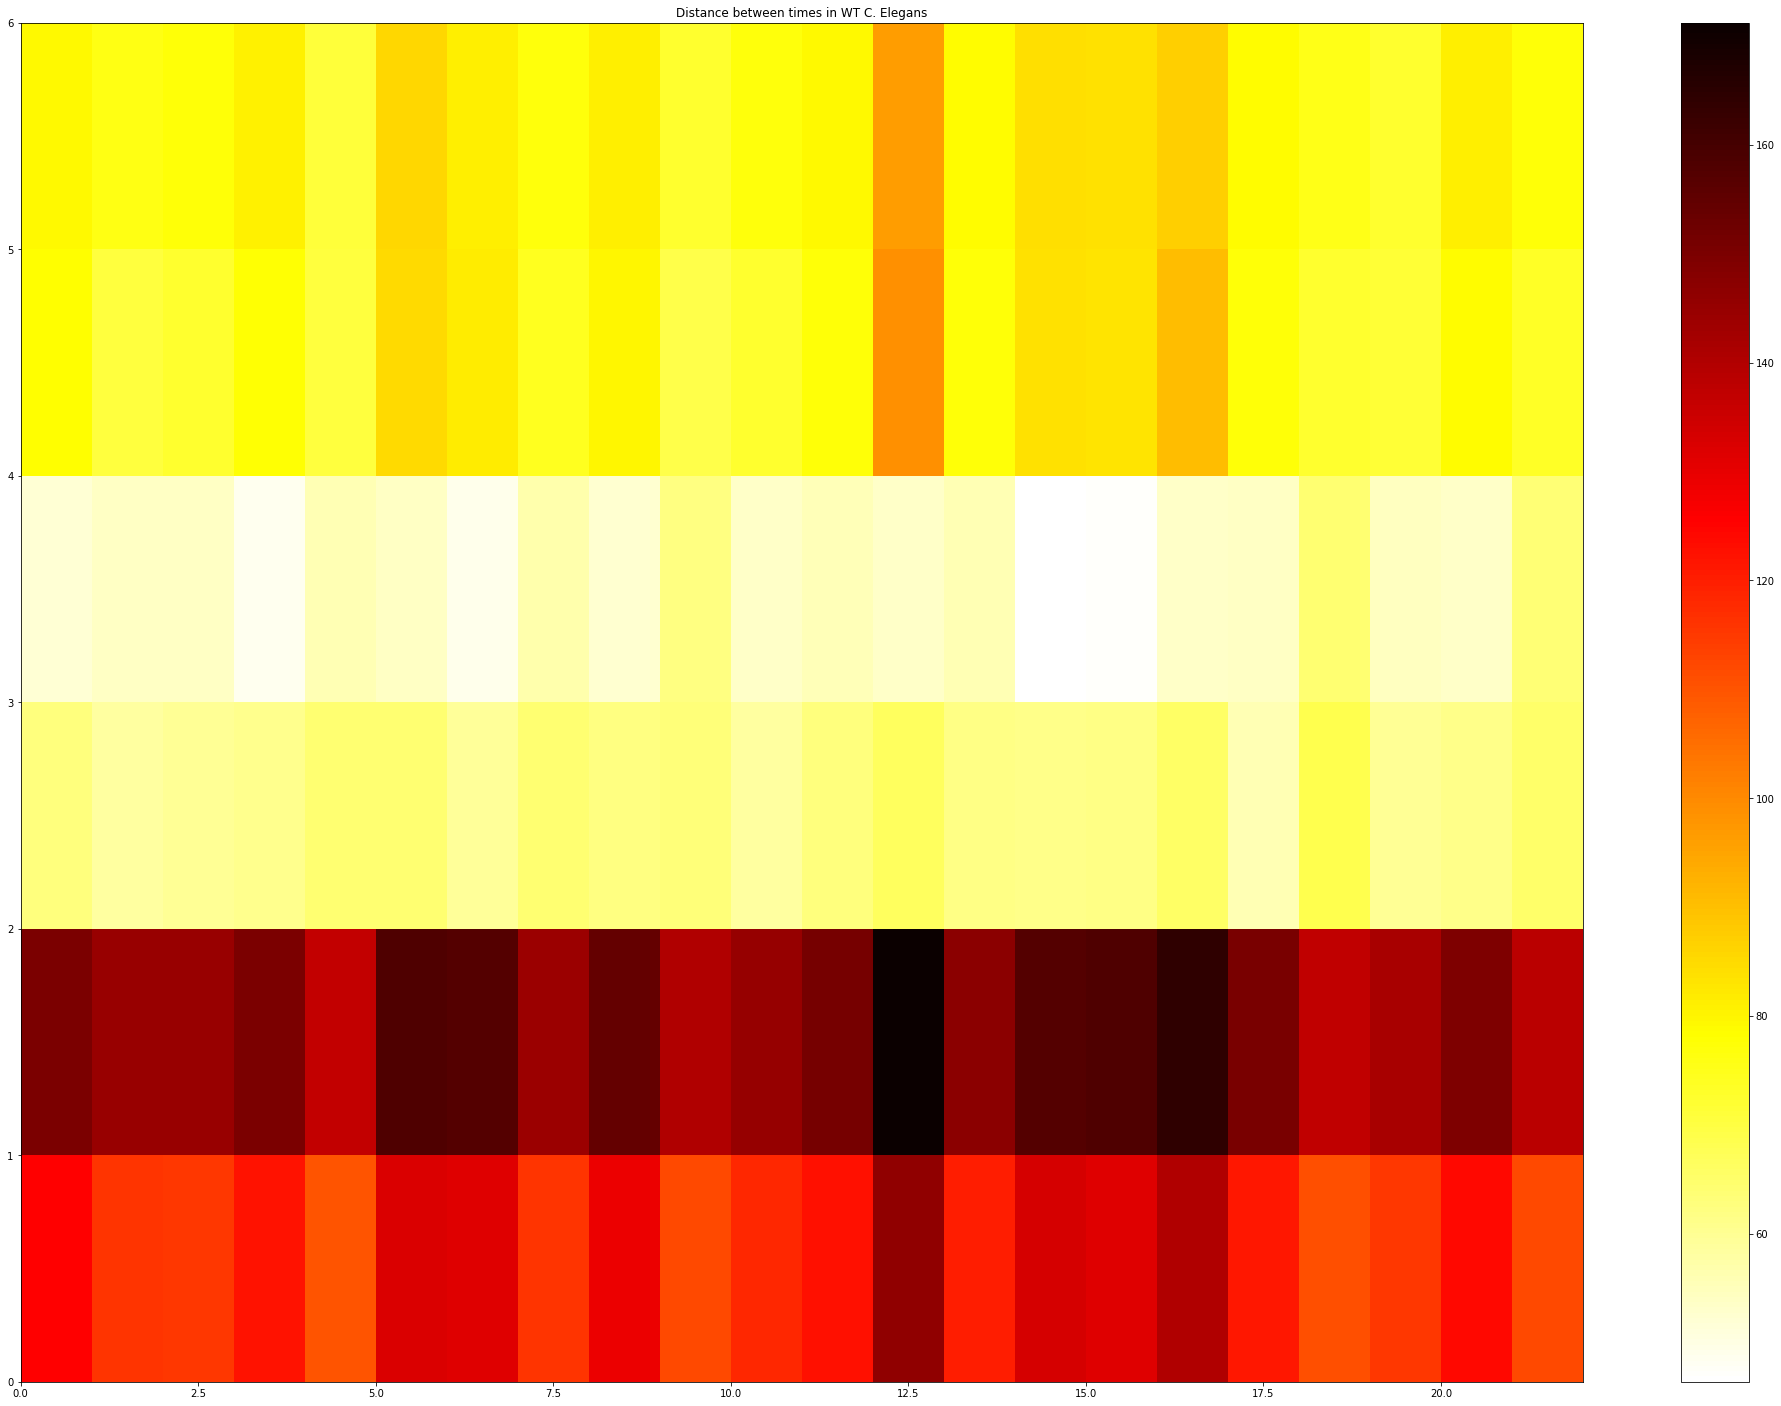

0.52
0.0
0.0
0.0
0.0
0.0


0.0
0.491
0.0
0.0
0.0
0.0


0.0
0.0
0.511
0.0
0.0
0.0


0.0
0.0
0.0
0.477
0.0
0.0


0.0
0.0
0.0
0.0
0.49
0.121


0.0
0.0
0.0
0.0
0.104
0.483




In [593]:
temp_b_mat = b2_mat[np.array(np.where(RNAi_name_array == 'ABI-1')) - 30][0]
plot_2_examples(['hot_r'],temp_b_mat)
p_value_matrix = []
for n in temp_b_mat:
    p_value_row = []
    ref_list_of_b_mats = n.tolist()[0]
    #print(list_of_b_mats)
    for m in temp_b_mat:
        second_list_of_b_mats = m.tolist()[0]
        #print(ref_list_of_b_mats,'\n',second_list_of_b_mats,'\n')
        #novel_two_sample_permutation_test(ref_list_of_b_mats,second_list_of_b_mats,30)
        print(novel_two_sample_permutation_test(ref_list_of_b_mats,second_list_of_b_mats,1000))
    print('\n')
    #print(n.tolist()[0],'\n')

In [577]:
np.mean(reference_WT_ingroup),np.std(reference_WT_ingroup)

(39.29671167294198, 5.599749662476889)

In [582]:
#RNAi_size_assignments

ABI-1 47.03430284568681 15.655915468395655
AMA-1 43.156695764715586 10.759473841152548
AOS-1 46.190298134125996 13.150019959955337
APR-1 47.138453564561544 13.823875320437782
APX-1 87.78141351630633 46.043789852013404
ARX-2 223.04948596616126 129.2594038238529
ATX-2 373.1309839043607 194.21406278613583
BUB-1 73.32352934524513 22.436429700161998
C01A2.5 114.18405128757259 26.612073041328294
C01F1.1 66.39819579778809 19.07300696792712
C02B10.5 119.15728364075386 60.465408002268084
C06A5.1 161.91482704375548 116.17932863654516
C07A9.2 104.48196035854919 40.14457156704039
C08B11.3 108.62288092089535 37.68570813435576
C49H3.8 54.89995972459102 14.120708984972577
C50F2.3 90.31067045632183 51.538815162907156
C55A6.9 95.32032416318526 32.40572541265691
CACN-1 111.61737968727755 56.69237018735773
CAMT-1 56.25655253723933 20.23611367394521
CBP-1 97.62564731041162 29.403508643637295
CDC-25.1 75.97649846131428 24.773262576834068
CDC-37 168.70124284347236 110.43193420220071
CDK-7 110.0434199652597 

Y52B11A.9 102.20367199862818 44.70879216287875
Y53F4B.22 188.1167121431602 117.68787510096669
Y71H2AM.17 284.06679126148157 76.03151606892501
ZYG-11 250.5165249635052 103.72459760722583
ZYG-12 124.46278790229235 31.088432222696273


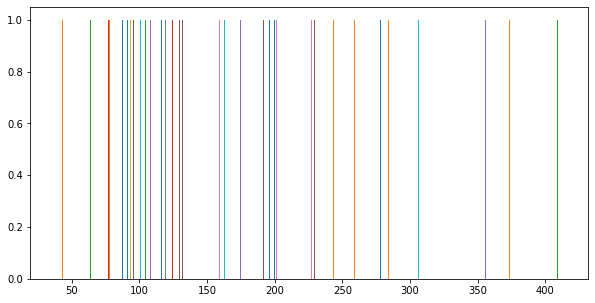

In [586]:
for n in list(RNAi_size_assignments)[2:]:
    internal_b_mat = []
    indices = np.array(np.array(np.where(RNAi_name_array == n)) - 30).tolist()[0]
    for a in indices:
        for b in indices:
            if a != b: internal_b_mat.append(branch_distance(fulldictset[a],fulldictset[b]))
    print(n,np.mean(internal_b_mat),np.std(internal_b_mat))
    try:
        plt.hist(np.mean(internal_b_mat))
    except:
        pass

In [572]:
set(RNAi_name_array)

{'ABI-1',
 'AMA-1',
 'AOS-1',
 'APR-1',
 'APX-1',
 'ARX-2',
 'ATX-2',
 'BUB-1',
 'C01A2.5',
 'C01F1.1',
 'C02B10.5',
 'C06A5.1',
 'C07A9.2',
 'C08B11.3',
 'C49H3.8',
 'C50F2.3',
 'C55A6.9',
 'CACN-1',
 'CAMT-1',
 'CBP-1',
 'CDC-25.1',
 'CDC-37',
 'CDK-7',
 'CDK-9',
 'CDT-1',
 'CEH-24',
 'CHAF-2',
 'CHC-1',
 'CHK-1',
 'CIR-1',
 'CLPF-1',
 'CLS-2',
 'CMD-1',
 'CPL-1',
 'CPSF-1',
 'CPSF-2',
 'CPSF-4',
 'CSN-4',
 'CUL-1',
 'CUL-2',
 'CUL-3',
 'D1043.1',
 'D1054.14',
 'D1081.8',
 'D2096.8',
 'DDX-23',
 'DIC-1',
 'DIE-1',
 'DIV-1',
 'DLC-1',
 'DLI-1',
 'DRH-3',
 'EGO-1',
 'ELB-1',
 'ELT-1',
 'EMB-5',
 'ETR-1',
 'F19F10.9',
 'F20D12.2',
 'F23F1.5',
 'F25B3.6',
 'F31C3.5',
 'F35F11.1',
 'F37C12.1',
 'F43E2.7',
 'F43G9.12',
 'F44B9.8',
 'F53B7.3',
 'F55A3.7',
 'GAD-1',
 'GEI-11',
 'GEI-17',
 'GLD-2',
 'GLP-1',
 'GOP-2',
 'GPB-1',
 'GSK-3',
 'HDA-1',
 'HEL-1',
 'HIM-10',
 'HIS-9',
 'HMP-2',
 'IMB-2',
 'K07C5.6',
 'KLP-10',
 'KLP-15',
 'KLP-16',
 'LAG-1',
 'LET-413',
 'LET-502',
 'LET-526',
 'LET

In [468]:
#temp_b_mat[5].tolist()[0],temp_b_mat[5].tolist()[0]

In [469]:
#novel_two_sample_permutation_test(temp_b_mat[5].tolist()[0],temp_b_mat[5].tolist()[0],1000)

In [470]:
#temp_b_mat

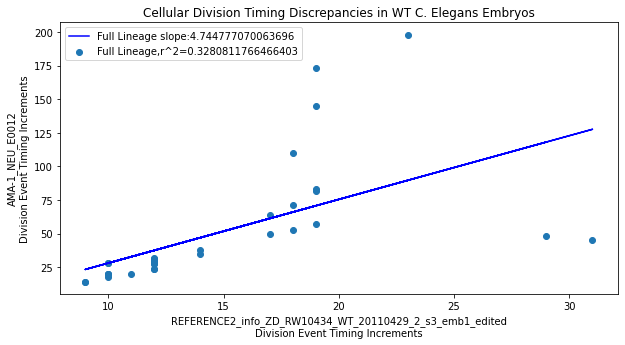

In [266]:
def dict_to_scatter_connect(name,lis,x,yname,ylis,y,img = False,seps='', tier = False):
    xaxis = [];yaxis = []
    target_xaxis=[];target_yaxis=[]
    if seps == '' or tier == True:
        for n in (list(set(lis[x]).intersection(set(ylis[y])))):
            xaxis.append(lis[x][n]);yaxis.append(ylis[y][n])
    else:
        target_xaxis=[];target_yaxis=[]
        for n in (list(set(lis[x]).intersection(set(ylis[y])))):
            if seps in n:
                target_xaxis.append(lis[x][n])
                target_yaxis.append(ylis[y][n])
            else:
                xaxis.append(lis[x][n]);yaxis.append(ylis[y][n])
    target_xaxis = np.array(target_xaxis);xaxis = np.array(xaxis)
    if tier == True: return xaxis, yaxis
    m, b, r, p_value, std_err = stats.linregress(np.append(xaxis,target_xaxis),yaxis+target_yaxis)
    #switch to siegelslope & theilsslope functions?
    name1,name2 = name[x].split('/')[-1][:-4],yname[y].split('/')[-1][:-4]
    if img == False: return m,b,r,name1,name2
    plt.scatter(xaxis,yaxis, label='Full Lineage,r^2='+str(r**2) ) #''', c = [0]*len(xaxis) ''')
    plt.title('Cellular Division Timing Discrepancies in WT C. Elegans Embryos');plt.xlabel(name1+'\nDivision Event Timing Increments');plt.ylabel(name2+'\nDivision Event Timing Increments')
    plt.plot(xaxis, (m*xaxis) + b, 'b-', label='Full Lineage slope:'+str(m), )
    if seps != '':
        target_xaxis = np.array(target_xaxis)
        m, b, r, p_value, std_err = stats.linregress(target_xaxis,target_yaxis)
        plt.plot(target_xaxis, (m*target_xaxis) + b, 'r-', label=seps+' slope:'+str(m))
        plt.scatter(target_xaxis,target_yaxis, label = seps+',r^2='+str(r**2) ) #''', c = [1]*len(target_xaxis) ''')
        xaxis = np.append(xaxis,target_xaxis); yaxis = np.append(yaxis,target_yaxis)
    m, b, r, p_value, std_err = stats.linregress(xaxis,yaxis)
    plt.legend(loc='upper left')
    #print(xaxis,target_xaxis)
    #print(np.append(xaxis,target_xaxis))
    #print(yaxis,target_yaxis)
    #print(np.append(yaxis,target_yaxis))
    #plt.savefig(name1+'&'+name2+'.png') #return m,b,r,name1,name2
    plt.show()
    
dict_to_scatter_connect(refnameset,refdictset,1,nameset,dictset,9,img=True)


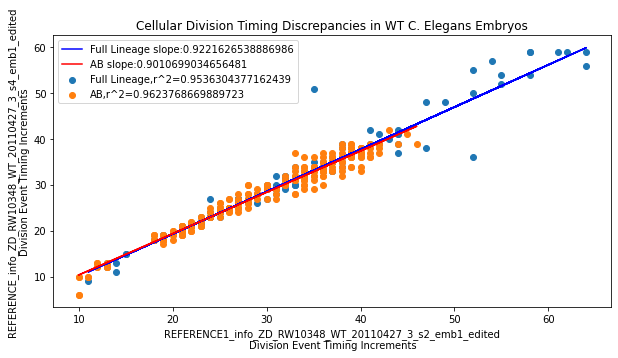

In [274]:
dict_to_scatter_connect(refnameset,refdictset,0,refnameset,refdictset,9,seps = 'AB',img=True)

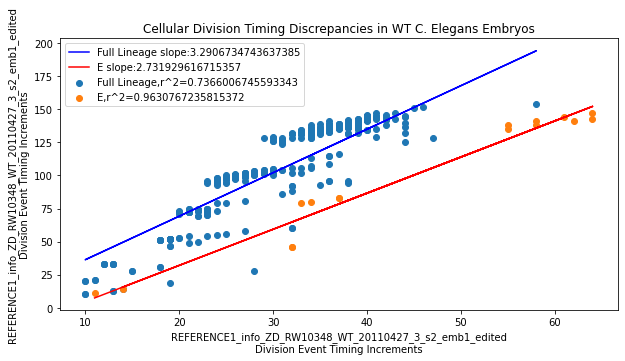

In [279]:
dict_to_scatter_connect(refnameset,refdictset,0,refnameset,refglobaldictset,0,seps = 'E',img=True)

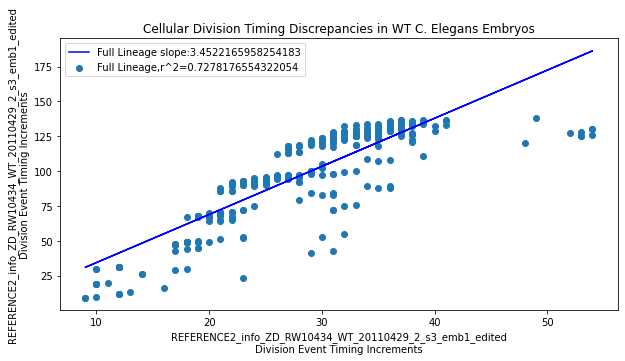

In [272]:
dict_to_scatter_connect(refnameset,refdictset,1,refnameset,refglobaldictset,1,img=True)

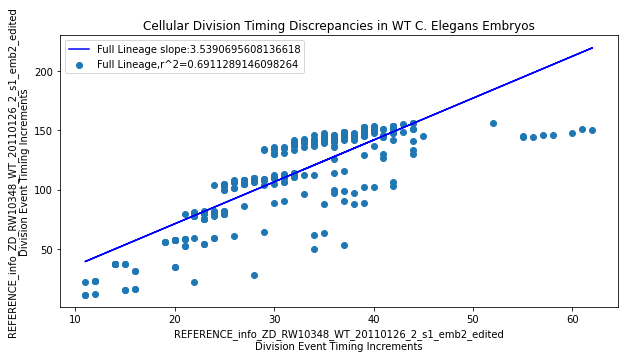

In [273]:
dict_to_scatter_connect(refnameset,refdictset,2,refnameset,refglobaldictset,2,img=True)

In [286]:
def dict_to_scatter_lineage(name,lis,x,name_,lis_,y,img = False,seps='', tier = False):
    #plt.figure().clear()
    gong = ['AB','C','D','MS','E','P']
    Subsetylist = [[],[],[],[],[],[]]
    Subsetxlist = [[],[],[],[],[],[]]
    xaxis = [];yaxis = []
    target_xaxis=[];target_yaxis=[]
    for n in (list(set(lis[x]).intersection(set(lis_[y])))):
        for m in range(0,len(gong)):
            if gong[m] in n:
                Subsetylist[m].append(lis[x][n]);Subsetxlist[m].append(lis_[y][n])
                continue
        xaxis.append(lis[x][n]);yaxis.append(lis_[y][n])
    target_xaxis = np.array(target_xaxis);xaxis = np.array(xaxis)
    m, b, r, p_value, std_err = stats.linregress(np.append(xaxis,target_xaxis),yaxis+target_yaxis)
    #switch to siegelslope & theilsslope functions?
    name1,name2 = name[x].split('/')[-1][:-4],name_[y].split('/')[-1][:-4]
    name1,name2 = name1[18:-7],name2[18:-7]
    plt.title('Embryonic Timing Discrepancies between '+name1+' &\n'+name2+' Common Nodes')
    plt.xlabel(name1+'\nDivision Event Timing Increments');plt.ylabel(name2+'\nDivision Event Timing Increments')
    for n in range(len(Subsetxlist)):
        plt.scatter(np.array(Subsetxlist[n]),Subsetylist[n], label=gong[n], s = [30] * len(Subsetxlist[n]), alpha = .35)
    plt.legend(loc='upper left')
    fig = plt.figure(1)
    rect = fig.patch
    rect.set_facecolor("white")
    hold = name1+'('+str(x)+')x'+name2+'('+str(y)+')_common'
    #plt.savefig(hold, facecolor=fig.get_facecolor())
    plt.show()
    print(name1+'('+str(x)+')x'+name2+'('+str(y)+')')
    plt.close()
    print(x,y)

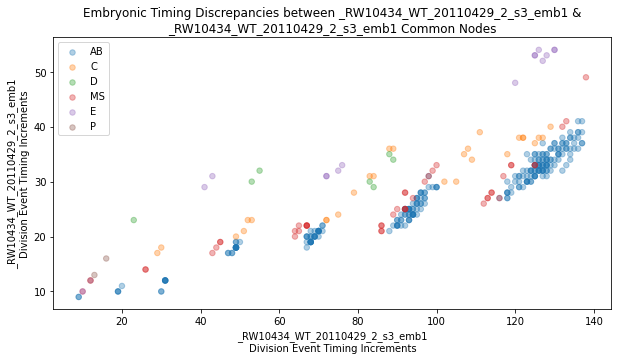

_RW10434_WT_20110429_2_s3_emb1(1)x_RW10434_WT_20110429_2_s3_emb1(1)
1 1


In [291]:
dict_to_scatter_lineage(refnameset,refdictset,1,refnameset,refglobaldictset,1,img=True)

In [ ]:
refscrambledictset,refglobalscrambledictset

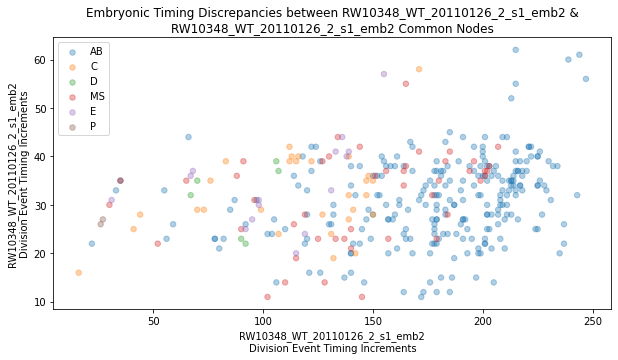

RW10348_WT_20110126_2_s1_emb2(2)xRW10348_WT_20110126_2_s1_emb2(2)
2 2


In [305]:
dict_to_scatter_lineage(refnameset,refscrambledictset,2,refnameset,refglobalscrambledictset,2,img=True)

In [592]:
def getKernelDensityEstimation(values, x, bandwidth = 0.2, kernel = 'gaussian'):
    model = KernelDensity(kernel = kernel, bandwidth=bandwidth)
    model.fit(values[:, np.newaxis])
    log_density = model.score_samples(x[:, np.newaxis])
    return np.exp(log_density)
data = list(reference_WT_ingroup)
for bandwidth in np.linspace(0.2, 3, 3):
    kde = getKernelDensityEstimation(data, x, bandwidth=bandwidth)
    plt.plot(x, kde, alpha = 0.8, label = f'bandwidth = {round(bandwidth, 2)}')
plt.plot(x, true_pdf, label = 'True PDF')
plt.legend()
plt.title('Effect of various bandwidth values \nThe larger the bandwidth, the smoother the approximation becomes');

NameError: name 'x' is not defined